In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt
/kaggle/input/yelpzip-kmeans-balanced/Наивный Байес_confusion_matrix.png
/kaggle/input/yelpzip-kmeans-balanced/Метод ближайших соседей_confusion_matrix.png
/kaggle/input/yelpzip-kmeans-balanced/Случайный лес_confusion_matrix.png
/kaggle/input/yelpzip-kmeans-balanced/Логистическая регрессия_confusion_matrix.png
/kaggle/input/yelpzip-kmeans-balanced/Мини-пакетный метод стохастического градиентного спуска_confusion_matrix.png
/kaggle/input/yelpzip-kmeans-balanced/yelp_zip_y_labels_balanced.csv
/kaggle/input/yelpzip-kmeans-balanced/yelp_zip_X_tf_idf_balanced.csv
/kaggle/input/yelpzip-kmeans-balanced/yelp_zip_kmeans_balancing.csv
/kaggle/input/yelpzip-kmeans-balanced/Машина опорных векторов_confusion_matrix.png
/kaggle/input/yelpzip-kmeans-balanced/Voting-классификатор_confusion_matrix.png


In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/word

In [3]:

def set_seed(seed: int = 42):
    import random
    """
    Фиксирует seed для всех источников случайности.

    Args:
        seed (int): Значение seed.
    """
    # Python's random module
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    
    # Если используется CUDA (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Для multi-GPU.

In [4]:
set_seed(42)

In [5]:
df = pd.read_csv('/kaggle/input/yelpzip-kmeans-balanced/yelp_zip_kmeans_balancing.csv')
df

,Unnamed: 0.1,Unnamed: 0,user_id,prod_id,rating,label,date,review,prod_name
0,19587,19587,22484,5032,5.0,1,2012-08-14,Delicious mac & cheese! Great vegan/veg option...,Khyber Pass Pub
1,252344,252344,145978,2174,5.0,1,2013-07-05,"great service, great food and cool atmosphere,...",Station House
2,451457,451457,139896,3136,2.0,1,2014-09-29,one of the worst pizzas ive had in nyc. the d...,Grimaldi’s
3,315427,315427,43630,3787,5.0,1,2011-04-15,"excellent, excellent, excellent food... Had th...",Saigon Shack
4,271982,271982,25936,2342,5.0,1,2014-10-06,Perfect roast pork sandwich with and a cheeses...,John’s Roast Pork
...,...,...,...,...,...,...,...,...,...
140434,608443,608443,265316,5042,5.0,-1,2014-12-24,I have been to this place for the third time i...,Ramayana Restaurant
140435,608446,608446,247830,5039,3.0,-1,2011-12-03,Best Subs does offer a large portione size how...,Best Subs the
140436,608447,608447,265318,5039,4.0,-1,2015-01-02,todays marks my 10th visit and have not had a ...,Best Subs the
140437,608448,608448,100625,5039,4.0,-1,2013-11-02,"The name says it all! Also, they make some kil...",Best Subs the


In [6]:
reviews_texts = df[['review', 'label']]
reviews_texts.isna().sum()

review    0
label     0
dtype: int64

In [7]:
# x_tfidf = pd.read_csv('/kaggle/input/kmeans-balanced-dataset/yelp_nyc_X_tf_idf_balanced.csv')

In [8]:
# x_tfidf.drop('Unnamed: 0', axis = 1, inplace = True)

In [9]:
# y_tfidf = pd.read_csv('/kaggle/input/kmeans-balanced-dataset/yelp_nyc_y_labels_balanced.csv')

In [10]:
# y_tfidf.drop('Unnamed: 0', axis = 1, inplace = True)

In [11]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression


In [12]:
# X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(x_tfidf, y_tfidf, test_size=0.2, random_state=42)

In [13]:
# X_train_tfidf.shape, X_test_tfidf.shape, y_train_tfidf.shape, y_test_tfidf.shape

In [14]:
# lr =  LogisticRegression(random_state=42)

# lr.fit(X_train_tfidf, y_train_tfidf)

In [15]:
# y_pred = lr.predict(X_test_tfidf)

In [16]:
# from sklearn.metrics import classification_report

# print(classification_report(y_test_tfidf, y_pred))

# Базовая предобработка текстов

In [17]:
! pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.9 MB/s eta 0:00:00


In [18]:
import re
import contractions

stop_words = set(stopwords.words('english'))
def preprocess_review(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\d'\s]", '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

text = "This is an example for wifes test 145 13 we're don't"
preprocess_review(text)

'example wifes test 145 13'

In [19]:
reviews_texts['review'] = reviews_texts['review'].apply(preprocess_review)

<ipython-input-19-b428cbb01f8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_texts['review'] = reviews_texts['review'].apply(preprocess_review)


In [20]:
reviews_texts['review'].head(10)

0    delicious mac cheese great veganveg options lo...
1    great service great food cool atmosphere loved...
2    one worst pizzas nyc dough really flat boring ...
3    excellent excellent excellent food sweet potat...
4    perfect roast pork sandwich cheesesteak fried ...
5    best sports bar jersey love bar tvs everywhere...
6    delicious food interesting dishes interestingg...
7    always wanted try place somehow never gotten a...
8    got tell ya used think old person bar used wal...
9    girlfriend works street eat often pizza averag...
Name: review, dtype: object

In [21]:
for r in reviews_texts['review']:
    splitted_r = r.split()
    short_reviews_list = []
    if len(splitted_r)<300:
        short_review = ' '.join(splitted_r)
        short_reviews_list.append(short_review)

print(len(short_reviews_list))
print(len(short_reviews_list[0].split()))


1
11


# Torch классы и функции

In [22]:
import matplotlib.pyplot as plt

In [23]:
def load_embedding_from_file(path_to_embedding):
    embeddings = {}
    with open(path_to_embedding, 'r', encoding='utf-8') as f:
        for line in f:
            splitted_line = line.strip().split()
            word = splitted_line[0]
            vector = np.array(splitted_line[1:])
            # print(word, vector, vector.shape)
            embeddings[word] = vector
    return embeddings
    

In [24]:
from collections import Counter

def build_vocabulary_and_embeddings(reviews, embeddings:dict, embedding_dim:int):
    vocabulary = {
        'PAD' : 0,
        'UKN' : 1,
    }

    counter = Counter()
    not_in_embeddings = []
    for review in reviews:
        counter.update(review.strip().split())
    # print(counter.most_common())

    # Построение словаря. most_common - для аггрегации слов
    for word, _ in counter.most_common():
        if word in embeddings:
            vocabulary[word] = len(vocabulary)
        else:
            not_in_embeddings.append(word)
    print('Кол-во слов, которых нет в эмбеддинге:', len(not_in_embeddings))

    embedding_matrix = np.zeros((len(vocabulary), embedding_dim))    

    for word, index in vocabulary.items():
        if word in embeddings:
            embedding_matrix[index] = embeddings[word]
        elif word == 'UKN':
            embedding_matrix[index] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return vocabulary, embedding_matrix
    
# vocabulary2, embedding_matrix2 = build_vocabulary_and_embeddings(['very good', 'very nice', 'super good'], 
                                                               # glove_dict, 
                                                               # 300)
# print(vocabulary2)
# print(embedding_matrix2[1])

In [25]:
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, vocabulary, embedding_matrix, max_len):
        self.reviews = reviews
        self.labels = labels
        self.vocabulary = vocabulary
        self.embedding_matrix = embedding_matrix
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index]
        label = self.labels[index]
        # работа с токенами в отзыве
        tokens = review.split()[:self.max_len] # берем определенное количество токенов
        inds = [self.vocabulary.get(tok, self.vocabulary['UKN']) for tok in tokens] # вычисляем их индексы
        # заполнение нулями
        padding_length = self.max_len - len(inds)
        inds += [self.vocabulary['PAD']] * padding_length
        return torch.tensor(inds), torch.tensor(label)

In [26]:
import numpy as np
import torch
class Early_stopping:
    def __init__(self, patience=3, delta=0.0, save_path='model_weights.pth'):
        self.patience = patience
        self.delta = delta
        self.save_path = save_path
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            print(f"Best loss: {self.best_loss}")
            self.counter = 0
            torch.save(model.state_dict(), self.save_path) # сохраняем веса наилучшей модели

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stopping triggered! Best model weights saved.")

In [27]:
def unfreeze_embeddings(model):
    for param in model.embedding.parameters():
         param.requires_grad = True
    print('Embeddings unfreeze')

In [28]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,classification_report, confusion_matrix

def compute_metrics(labels, preds):
    # Преобразуем предсказания в вероятности (если нужно)
    # print(preds)
    # preds = [int(p) for p in preds]
    # preds_classes = np.round(probs).astype(int)

    if np.any(np.isnan(preds)):
        print("Warning: NaN values found in predictions!")
        preds = np.nan_to_num(preds)  # Заменяем NaN на 0
    preds_classes = np.round(preds).astype(int)
    
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)
    f1 = f1_score(labels, preds, zero_division=0)
    auc = roc_auc_score(labels, preds) 
    # if len(np.unique(labels)) > 1 else 0.5  # AUC требует обоих классов

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'F1': f1,
        'AUC': auc
    }

def show_metrics(y_true, y_pred, title):
    print(f'''
                {title}
==========================================
 auc: {roc_auc_score(y_true, y_pred)}             
==========================================
 report:                                
{classification_report(y_true, y_pred)}
==========================================

    ''')    

def show_confusion_matrix(y_true, y_pred, title_string):
    conf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.title(title_string)
    sns.heatmap(conf, fmt='d', annot=True)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()

In [29]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs, early_stopping=None):
    # сохраняем историю во время обучения
    history = {
        'train_loss':[],
        'train_accuracy' :[],
        'train_precision':[],
        'train_recall':[],
        'train_F1':[],
        'train_AUC': [],
        'val_loss':[],
        
        'val_accuracy' :[],
        'val_precision':[],
        'val_recall':[],
        'val_F1':[],
        'val_AUC':[]
    }   

    grad_logs = {}
    flag_freeze = False
    
    for epoch in tqdm(range(num_epochs), desc="Epochs", position=0): 
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 20)

        # Режим обучения
        model.train()
        train_losses = []
        train_preds = []
        train_labels = []
        print('-----Обучение-----')
        for inputs, labels in train_loader:
        # with torch.autograd.detect_anomaly():
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad() # обнуляем градиенты для текущего батча
            outputs = model(inputs) # вычисляем выход модели

            # if (epoch == 12) and not(flag_freeze) :
            #     unfreeze_embeddings(model)
            #     flag_freeze = True
            
            
            if torch.any(torch.isnan(outputs)):
                print("NAN значения среди outputs!")
                print(outputs[:4])
                return history, grad_logs
            
            loss = criterion(outputs, labels) # вычисляем loss для батча
            if torch.isnan(loss):
                print("NaN в лоссе!")
                print(f'''
                -----------------------
                -----------------------
                loss: {loss}
                -----------------------
                -----------------------
                inputs: {inputs}
                -----------------------
                -----------------------
                outputs: {outputs}
                -----------------------
                -----------------------
                
                ''')
                return history, grad_logs
            train_losses.append(loss.item()) 
            loss.backward()
                
            # вывод градиента, проверка на взрыв/затухание
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if name not in grad_logs.keys():
                        grad_logs[name] = []    
                    grad_logs[name].append(param.grad.norm().item())
                    
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            
            optimizer.step()

            preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
            if np.any(np.isnan(preds[:4])):
                print("NAN значения среди preds!")
                print(preds)
                return history, grad_logs
            labels = labels.detach().cpu().numpy()
            train_preds.extend(preds.flatten())
            train_labels.extend(labels.flatten())
        # считаем показатели после эпохи
        train_loss = sum(train_losses) / len(train_losses) # среднее на эпохе
        train_metrics = compute_metrics(train_labels, train_preds) # метрики на эпохе
        # сохранем историю после эпохи
        for name, value in train_metrics.items():
            history[f"train_{name}"].append(value)
        history['train_loss'].append(train_loss)
        #======#
        
        # режим валидации
        model.eval()
        val_losses = []
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())

                preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()

                val_preds.extend(preds)
                val_labels.extend(labels)
            
            val_loss = sum(val_losses) / len(val_losses)
            val_metrics = compute_metrics(val_labels, val_preds)
            for metric_name, metric_value in val_metrics.items():
                history[f'val_{metric_name}'].append(metric_value)
            history['val_loss'].append(val_loss)
         # Вывод метрик
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_metrics["accuracy"]:.4f} | ',
              f'Train Precision: {train_metrics["precision"]:.4f} | Train Recall: {train_metrics["recall"]:.4f} | ',
              f'Train F1: {train_metrics["F1"]:.4f} | Train AUC: {train_metrics["AUC"]:.4f}')
        
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_metrics["accuracy"]:.4f} | ',
              f'Val Precision: {val_metrics["precision"]:.4f} | Val Recall: {val_metrics["recall"]:.4f} | ',
              f'Val F1: {val_metrics["F1"]:.4f} | Val AUC: {val_metrics["AUC"]:.4f}')

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print(f'Stop after {epoch} epochs')
                return history, grad_logs
        
    return history, grad_logs

In [30]:
def plot_metrics(history, model_name):
    """
    Визуализирует метрики из словаря history.

    :param history: Словарь, содержащий метрики обучения и валидации.
    """
    # Проверяем, есть ли данные для визуализации
    if not history:
        print("Словарь history пуст.")
        return

    # Извлекаем метрики из history
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'F1', 'AUC']
    train_metrics = [f'train_{metric}' for metric in metrics]
    val_metrics = [f'val_{metric}' for metric in metrics]

    # Создаём графики для каждой метрики
    plt.figure(figsize=(15, 10))
    plt.title(f"Процесс обучения {model_name}")
    for i, (metric, val_metric) in enumerate(zip(train_metrics, val_metrics)):
        plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика
        if metric in history:
            plt.plot(history[metric], label=f'Обучение')
        if val_metric in history:
            plt.plot(history[val_metric], label=f'Валидация')

        plt.title(metric.capitalize()[6:])
        plt.xlabel('Эпохи')
        plt.ylabel("Значения метрики")
        plt.legend()
    plt.savefig(f'Процесс обучения {model_name}')
    plt.tight_layout()
    plt.show()

In [31]:
def eval_model(model, test_loader, criterion, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating(test)"):
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            preds = torch.sigmoid(outputs).round().detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.flatten())

    metrics = compute_metrics(all_labels, all_preds)
    metrics['loss'] = sum(losses) / len(losses)
    return sum(losses) / len(losses), metrics, all_labels, all_preds
            

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics_eval(history_dict, model_name):
    keys = list(history_dict.keys())
    values = list(map(lambda x: round(x, 4), list(history_dict.values())))
    
    print(keys)
    print(values)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(x=keys, y=values)
    plt.xlabel('Метрики')
    plt.ylabel('Значения метрик')
    plt.title(f'Метрики {model_name} на тестовой выборке')
    for p, l in zip(ax.patches, values):
        ax.text(p.get_x() + p.get_width() / 2, p.get_height(), l, ha = 'center', va = 'bottom')   
    plt.legend()

    plt.savefig(f'Метрики {model_name} на тестовой выборке.png')
    plt.tight_layout()
    plt.show()

# Предобработка

In [33]:
reviews_texts.head(4)

,review,label
0,delicious mac cheese great veganveg options lo...,1
1,great service great food cool atmosphere loved...,1
2,one worst pizzas nyc dough really flat boring ...,1
3,excellent excellent excellent food sweet potat...,1


In [34]:
reviews_texts['label'] = reviews_texts['label'].replace(-1, 0)
reviews_texts.tail(4)


<ipython-input-34-affa42ad5df4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_texts['label'] = reviews_texts['label'].replace(-1, 0)


,review,label
140435,best subs offer large portione size however ch...,0
140436,todays marks 10th visit bad sandwich yet 7 buc...,0
140437,name says also make killer chili cheese fries,0
140438,love place eating hear years food totally wort...,0


In [35]:
glove_path = '/kaggle/input/glove-embeddings/glove.6B.300d.txt'
glove_dict = load_embedding_from_file(glove_path)


In [36]:
vocabulary, embedding_matrix = build_vocabulary_and_embeddings(reviews_texts['review'], embeddings=glove_dict, embedding_dim=300)


Кол-во слов, которых нет в эмбеддинге: 79525


In [37]:
print(len(vocabulary))
print(embedding_matrix.shape)
# ukn = vocabulary['UKN']
# print(ukn)
# print(embedding_matrix[ukn])

print(vocabulary.get('qqqqq', vocabulary['UKN']))


50876
(50876, 300)
1


In [38]:
pad = vocabulary['PAD']
print(pad)
print(embedding_matrix[pad])
type(embedding_matrix)

0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


numpy.ndarray

In [39]:
vocabulary_keys = list(vocabulary.keys())
not_in_glove = []
for key in vocabulary_keys:
    if key not in glove_dict.keys():
        not_in_glove.append(key)
print(not_in_glove)
    

['PAD', 'UKN']


In [40]:
reviews_texts['review']

0         delicious mac cheese great veganveg options lo...
1         great service great food cool atmosphere loved...
2         one worst pizzas nyc dough really flat boring ...
3         excellent excellent excellent food sweet potat...
4         perfect roast pork sandwich cheesesteak fried ...
                                ...                        
140434    place third time week great lunch plus dinner ...
140435    best subs offer large portione size however ch...
140436    todays marks 10th visit bad sandwich yet 7 buc...
140437        name says also make killer chili cheese fries
140438    love place eating hear years food totally wort...
Name: review, Length: 140439, dtype: object

In [41]:
full_dataset = ReviewsDataset(reviews = reviews_texts['review'], 
                             labels = reviews_texts['label'],
                             vocabulary = vocabulary,
                             embedding_matrix = embedding_matrix,
                             max_len = 256
                            )

In [42]:
from torch.utils.data import random_split
generator = torch.Generator().manual_seed(42)
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [0.75, 0.05, 0.2], generator=generator)

print(f"""
Размер тренировочного набора: {len(train_dataset)}, 
Размер валидационного набора: {len(valid_dataset)}, 
Размер тестового набора: {len(test_dataset)}, 
"""
)


Размер тренировочного набора: 105330, 
Размер валидационного набора: 7022, 
Размер тестового набора: 28087, 



In [43]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in train_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [44]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in valid_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [45]:
# cnt_fake, cnt_true = 0, 0
# for _, labels in test_loader:
#         cnt_fake += (labels==0).sum()
#         cnt_true += (labels==1).sum()
    
# print('фейковые: ', cnt_fake, 'настоящие: ', cnt_true)

In [46]:
train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 256, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32)


# Модели

In [47]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

In [48]:
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:  # Веса входного слоя
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:  # Веса рекуррентного слоя
                init.orthogonal_(param.data)  
            elif 'bias' in name:  # Смещения (bias)
                param.data.fill_(0)

    elif isinstance(m, nn.Linear):  # Полносвязный слой
        init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0)

# Simple LSTM

In [49]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.005
num_epochs = 100
dropout_rate = 0.25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [50]:
simple_lstm_model = nn.Sequential(
    nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32)),
    nn.Dropout(dropout_rate),
    nn.LSTM(input_size=embedding_matrix.shape[1], hidden_size=hidden_dim, batch_first=True),
    nn.Linear(hidden_dim, output_dim)
)
print(simple_lstm_model)

Sequential(
  (0): Embedding(50876, 300)
  (1): Dropout(p=0.25, inplace=False)
  (2): LSTM(300, 256, batch_first=True)
  (3): Linear(in_features=256, out_features=1, bias=True)
)


## Обучение Simple LSTM

In [51]:
class LSTM_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTM_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad = True # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
                            input_size=embedding_matrix.shape[1],
                            num_layers=1,
                            hidden_size=hidden_dim,
                            batch_first=True,
                           )
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Берем последний таймстеп
        output = self.fc2(lstm_out)
        return output
        

In [52]:
simple_lstm_model = LSTM_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate)

In [53]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(simple_lstm_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=6, delta=0.001, save_path='simple_lstm_model.pth')
simple_lstm_model.to(device)

LSTM_model(
  (embedding): Embedding(50876, 300)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [54]:
history, _ = train_model(model=simple_lstm_model, 
                        train_loader=train_loader,
                        valid_loader=valid_loader, 
                        criterion=criterion, 
                        optimizer=optimizer, 
                        device=device, 
                        num_epochs=num_epochs, 
                        early_stopping=early_stopping
                        )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:43<1:12:25, 43.89s/it]

Train Loss: 0.6828 | Train Acc: 0.5740 |  Train Precision: 0.5313 | Train Recall: 0.0087 |  Train F1: 0.0171 | Train AUC: 0.5015
Val Loss: 0.6827 | Val Acc: 0.5722 |  Val Precision: 0.6341 | Val Recall: 0.0086 |  Val F1: 0.0170 | Val AUC: 0.5024
Best loss: 0.682741886803082

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [01:29<1:13:03, 44.73s/it]

Train Loss: 0.6827 | Train Acc: 0.5753 |  Train Precision: 0.5779 | Train Recall: 0.0148 |  Train F1: 0.0288 | Train AUC: 0.5034
Val Loss: 0.6828 | Val Acc: 0.5722 |  Val Precision: 0.7037 | Val Recall: 0.0063 |  Val F1: 0.0125 | Val AUC: 0.5022

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [02:19<1:16:07, 47.08s/it]

Train Loss: 0.6357 | Train Acc: 0.6475 |  Train Precision: 0.6570 | Train Recall: 0.3623 |  Train F1: 0.4671 | Train AUC: 0.6109
Val Loss: 0.5992 | Val Acc: 0.6844 |  Val Precision: 0.6530 | Val Recall: 0.5655 |  Val F1: 0.6061 | Val AUC: 0.6697
Best loss: 0.5991694373743874

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [03:07<1:15:59, 47.49s/it]

Train Loss: 0.5706 | Train Acc: 0.7140 |  Train Precision: 0.7032 | Train Recall: 0.5698 |  Train F1: 0.6295 | Train AUC: 0.6955
Val Loss: 0.5844 | Val Acc: 0.6995 |  Val Precision: 0.6824 | Val Recall: 0.5615 |  Val F1: 0.6161 | Val AUC: 0.6824
Best loss: 0.5844108441046306

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [03:55<1:15:53, 47.93s/it]

Train Loss: 0.5313 | Train Acc: 0.7435 |  Train Precision: 0.7333 | Train Recall: 0.6263 |  Train F1: 0.6756 | Train AUC: 0.7285
Val Loss: 0.5963 | Val Acc: 0.6911 |  Val Precision: 0.6471 | Val Recall: 0.6172 |  Val F1: 0.6318 | Val AUC: 0.6820

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [04:44<1:15:16, 48.05s/it]

Train Loss: 0.4971 | Train Acc: 0.7657 |  Train Precision: 0.7575 | Train Recall: 0.6625 |  Train F1: 0.7068 | Train AUC: 0.7524
Val Loss: 0.6103 | Val Acc: 0.6894 |  Val Precision: 0.6583 | Val Recall: 0.5751 |  Val F1: 0.6139 | Val AUC: 0.6753

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [05:32<1:14:42, 48.20s/it]

Train Loss: 0.4643 | Train Acc: 0.7854 |  Train Precision: 0.7801 | Train Recall: 0.6916 |  Train F1: 0.7332 | Train AUC: 0.7733
Val Loss: 0.6337 | Val Acc: 0.6871 |  Val Precision: 0.6473 | Val Recall: 0.5960 |  Val F1: 0.6206 | Val AUC: 0.6758

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [06:20<1:13:52, 48.18s/it]

Train Loss: 0.4352 | Train Acc: 0.8008 |  Train Precision: 0.7989 | Train Recall: 0.7119 |  Train F1: 0.7529 | Train AUC: 0.7894
Val Loss: 0.6642 | Val Acc: 0.6794 |  Val Precision: 0.6419 | Val Recall: 0.5731 |  Val F1: 0.6056 | Val AUC: 0.6663

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [07:09<1:13:09, 48.24s/it]

Train Loss: 0.4112 | Train Acc: 0.8144 |  Train Precision: 0.8136 | Train Recall: 0.7327 |  Train F1: 0.7710 | Train AUC: 0.8039
Val Loss: 0.6696 | Val Acc: 0.6750 |  Val Precision: 0.6413 | Val Recall: 0.5516 |  Val F1: 0.5931 | Val AUC: 0.6597

Epoch 10/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [07:57<1:20:30, 53.08s/it]

Train Loss: 0.3889 | Train Acc: 0.8250 |  Train Precision: 0.8272 | Train Recall: 0.7452 |  Train F1: 0.7840 | Train AUC: 0.8147
Val Loss: 0.7021 | Val Acc: 0.6784 |  Val Precision: 0.6556 | Val Recall: 0.5290 |  Val F1: 0.5855 | Val AUC: 0.6599
Early stopping triggered! Best model weights saved.
Stop after 9 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


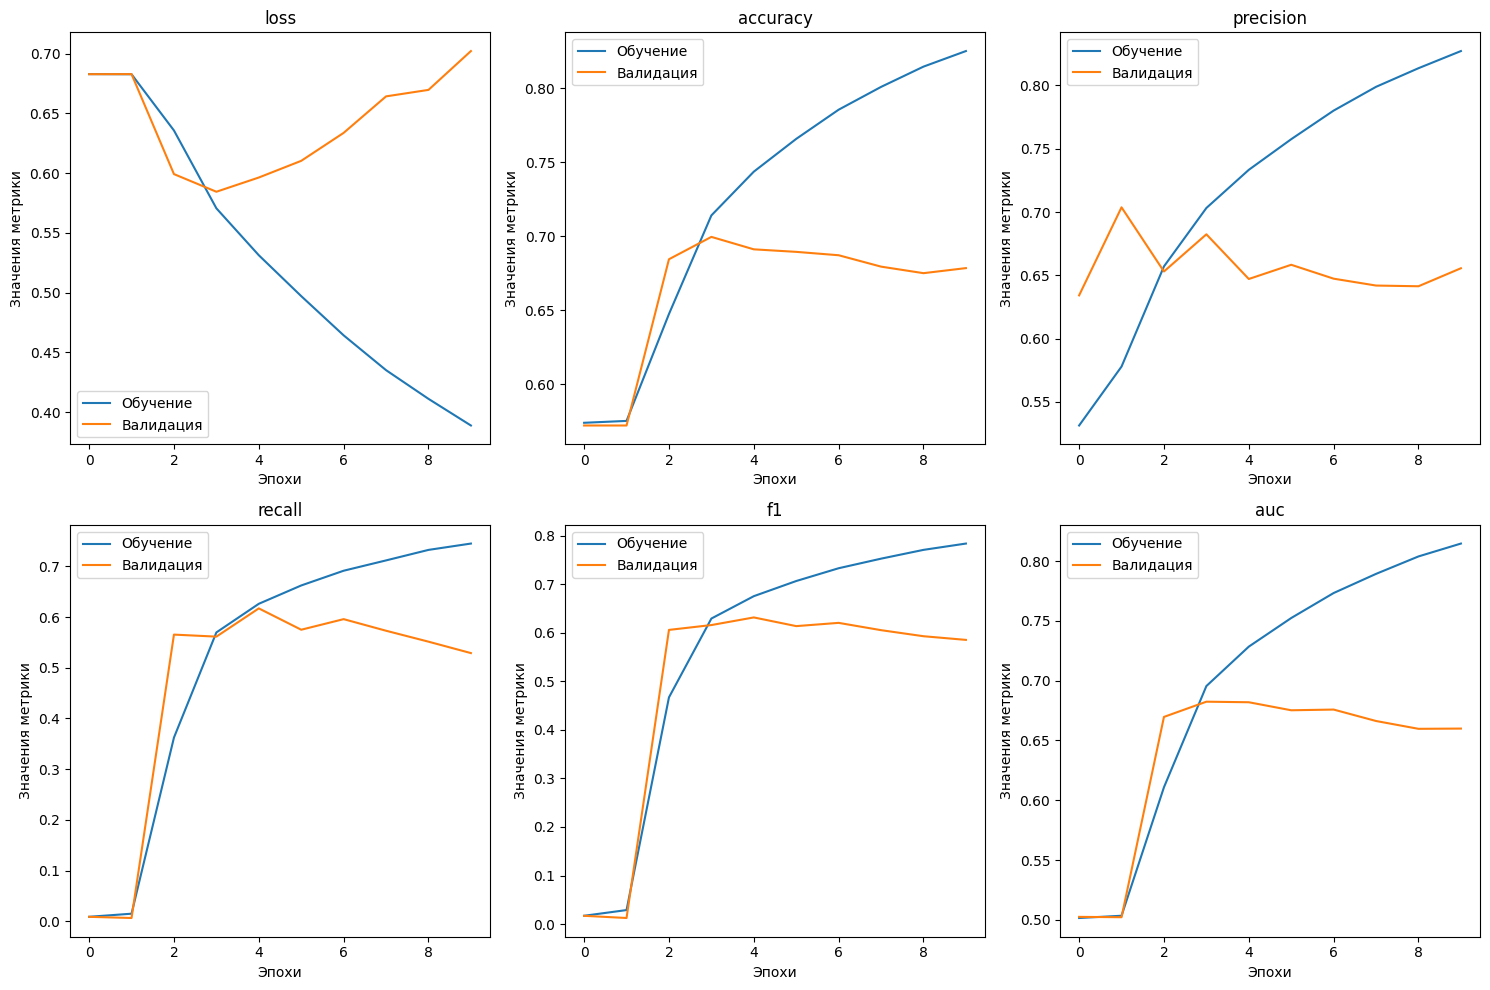

In [55]:
plot_metrics(history, model_name = 'LSTM')

In [56]:
simple_lstm_model.load_state_dict(torch.load('simple_lstm_model.pth', weights_only=True))

<All keys matched successfully>

## Оценка Simple LSTM

In [57]:
_, metrics, labels, preds = eval_model(simple_lstm_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 878/878 [00:07<00:00, 122.44it/s]


In [58]:
show_metrics(labels, preds, 'LSTM')


                LSTM
 auc: 0.6806701755333334             
 report:                                
              precision    recall  f1-score   support

         0.0       0.71      0.81      0.75     16015
         1.0       0.68      0.55      0.61     12072

    accuracy                           0.70     28087
   macro avg       0.70      0.68      0.68     28087
weighted avg       0.70      0.70      0.69     28087


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.6986, 0.685, 0.5531, 0.612, 0.6807, 0.5853]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


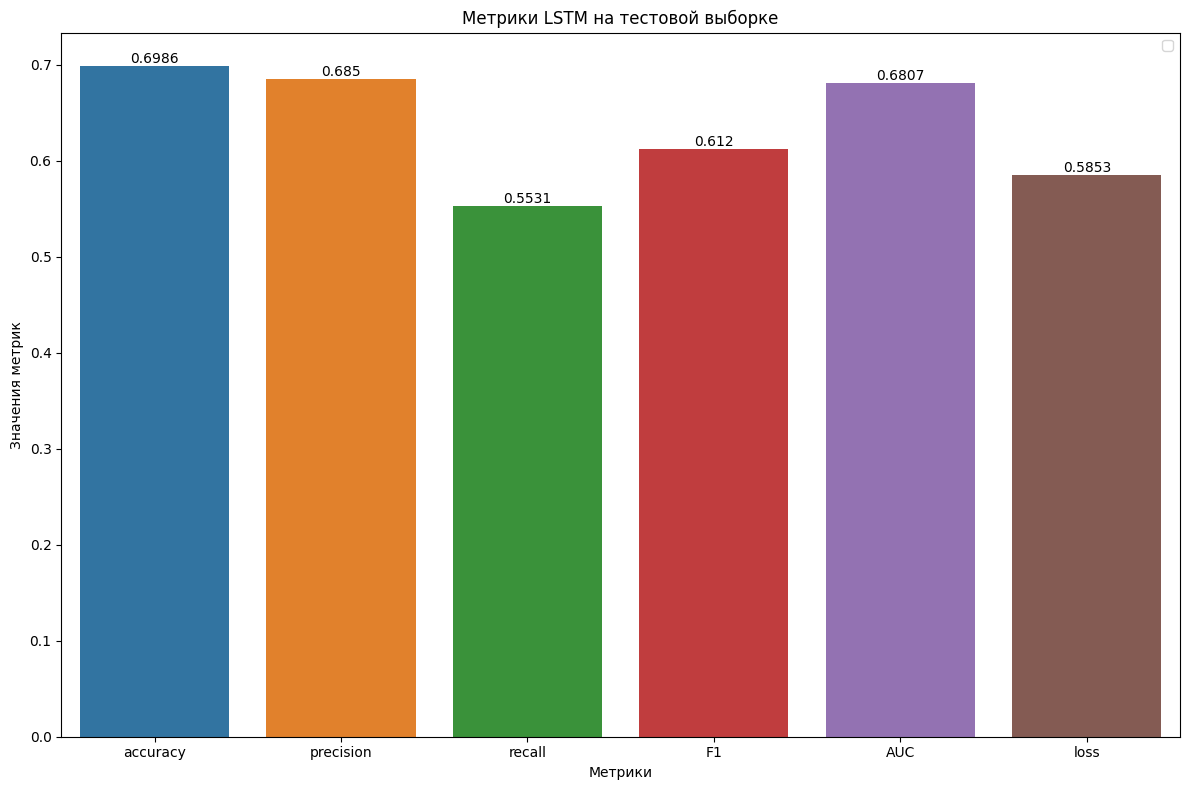

In [59]:
plot_metrics_eval(metrics, 'LSTM')

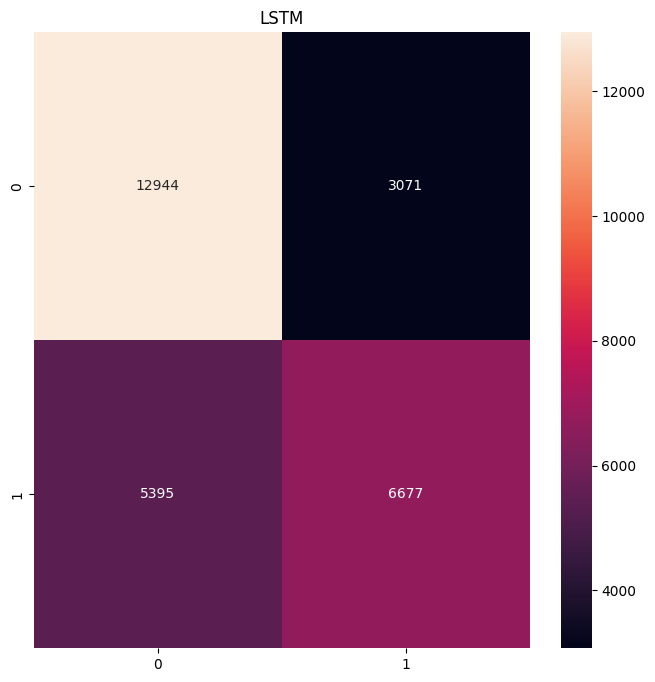

In [60]:
show_confusion_matrix(labels, preds, 'LSTM')

# Simple GRU

In [61]:
class GRU_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(GRU_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight.requires_grad = True # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.gru = nn.GRU(
                            input_size=embedding_matrix.shape[1],
                            num_layers=1,
                            hidden_size=hidden_dim,
                            batch_first=True,
                           ).to(device)
        # self.fc1 = nn.Linear(hidden_dim, 128).to(device)
        # self.relu = nn.ReLU().to(device)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        gru_out, _ = self.gru(embedded)
        gru_out = gru_out[:, -1, :]  # Берем последний таймстеп
        # fc1_out = self.fc1(lstm_out)
        # fc1_out = self.relu(fc1_out)
        output = self.fc2(gru_out)
        return output
        

## Обучение Simple GRU

In [62]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)



cuda


In [63]:
embedding_dim

300

In [64]:

simple_gru_model = GRU_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate)

In [65]:
print(simple_gru_model)


GRU_model(
  (embedding): Embedding(50876, 300)
  (embedding_dropout): Dropout(p=0.25, inplace=False)
  (gru): GRU(300, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [66]:
simple_gru_model.to(device)
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(simple_gru_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=5, delta=0.0001, save_path = "simple_GRU.pth")


In [67]:
history, grad_logs = train_model(simple_gru_model, train_loader, valid_loader, criterion, optimizer, device, num_epochs, early_stopping)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [00:39<1:04:30, 39.09s/it]

Train Loss: 0.6825 | Train Acc: 0.5741 |  Train Precision: 0.5325 | Train Recall: 0.0090 |  Train F1: 0.0176 | Train AUC: 0.5016
Val Loss: 0.6829 | Val Acc: 0.5713 |  Val Precision: 0.5926 | Val Recall: 0.0053 |  Val F1: 0.0105 | Val AUC: 0.5013
Best loss: 0.6829264461994171

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [01:18<1:04:28, 39.47s/it]

Train Loss: 0.6814 | Train Acc: 0.5758 |  Train Precision: 0.7328 | Train Recall: 0.0081 |  Train F1: 0.0159 | Train AUC: 0.5029
Val Loss: 0.6831 | Val Acc: 0.5716 |  Val Precision: 0.7059 | Val Recall: 0.0040 |  Val F1: 0.0079 | Val AUC: 0.5014

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [01:58<1:04:14, 39.73s/it]

Train Loss: 0.6776 | Train Acc: 0.5814 |  Train Precision: 0.7358 | Train Recall: 0.0285 |  Train F1: 0.0549 | Train AUC: 0.5105
Val Loss: 0.6740 | Val Acc: 0.5706 |  Val Precision: 0.5000 | Val Recall: 0.0020 |  Val F1: 0.0040 | Val AUC: 0.5002
Best loss: 0.6739645387445178

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [02:39<1:03:49, 39.89s/it]

Train Loss: 0.6811 | Train Acc: 0.5774 |  Train Precision: 0.6074 | Train Recall: 0.0252 |  Train F1: 0.0485 | Train AUC: 0.5066
Val Loss: 0.7175 | Val Acc: 0.5716 |  Val Precision: 0.5467 | Val Recall: 0.0136 |  Val F1: 0.0265 | Val AUC: 0.5026

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [03:19<1:03:24, 40.05s/it]

Train Loss: 0.6337 | Train Acc: 0.6446 |  Train Precision: 0.6797 | Train Recall: 0.3148 |  Train F1: 0.4303 | Train AUC: 0.6023
Val Loss: 0.5912 | Val Acc: 0.6881 |  Val Precision: 0.6897 | Val Recall: 0.4975 |  Val F1: 0.5780 | Val AUC: 0.6645
Best loss: 0.5911516313041959

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [03:59<1:02:51, 40.12s/it]

Train Loss: 0.5659 | Train Acc: 0.7112 |  Train Precision: 0.6977 | Train Recall: 0.5694 |  Train F1: 0.6271 | Train AUC: 0.6930
Val Loss: 0.5780 | Val Acc: 0.6974 |  Val Precision: 0.6485 | Val Recall: 0.6444 |  Val F1: 0.6465 | Val AUC: 0.6908
Best loss: 0.5779654915843692

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [04:39<1:02:10, 40.11s/it]

Train Loss: 0.5164 | Train Acc: 0.7474 |  Train Precision: 0.7339 | Train Recall: 0.6397 |  Train F1: 0.6835 | Train AUC: 0.7336
Val Loss: 0.5821 | Val Acc: 0.7012 |  Val Precision: 0.6733 | Val Recall: 0.5907 |  Val F1: 0.6293 | Val AUC: 0.6875

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [05:19<1:01:30, 40.11s/it]

Train Loss: 0.4605 | Train Acc: 0.7818 |  Train Precision: 0.7720 | Train Recall: 0.6928 |  Train F1: 0.7302 | Train AUC: 0.7703
Val Loss: 0.6445 | Val Acc: 0.6903 |  Val Precision: 0.6789 | Val Recall: 0.5287 |  Val F1: 0.5944 | Val AUC: 0.6703

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [05:59<1:00:45, 40.06s/it]

Train Loss: 0.4017 | Train Acc: 0.8153 |  Train Precision: 0.8100 | Train Recall: 0.7404 |  Train F1: 0.7737 | Train AUC: 0.8057
Val Loss: 0.6868 | Val Acc: 0.6702 |  Val Precision: 0.6176 | Val Recall: 0.6090 |  Val F1: 0.6132 | Val AUC: 0.6626

Epoch 10/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [06:39<1:00:05, 40.06s/it]

Train Loss: 0.3482 | Train Acc: 0.8443 |  Train Precision: 0.8442 | Train Recall: 0.7784 |  Train F1: 0.8100 | Train AUC: 0.8358
Val Loss: 0.7732 | Val Acc: 0.6693 |  Val Precision: 0.6438 | Val Recall: 0.5144 |  Val F1: 0.5719 | Val AUC: 0.6502

Epoch 11/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [07:20<1:06:00, 44.00s/it]

Train Loss: 0.3009 | Train Acc: 0.8675 |  Train Precision: 0.8691 | Train Recall: 0.8115 |  Train F1: 0.8393 | Train AUC: 0.8603
Val Loss: 0.8357 | Val Acc: 0.6653 |  Val Precision: 0.6359 | Val Recall: 0.5161 |  Val F1: 0.5698 | Val AUC: 0.6469
Early stopping triggered! Best model weights saved.
Stop after 10 epochs


In [68]:
# for key in grad_logs.keys():
#     print(key, grad_logs[key][-150:])

In [69]:
# for key in grad_logs.keys():
#     print(key, max(grad_logs[key]))
#     print(key, min(grad_logs[key]))
#     print()
    

<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


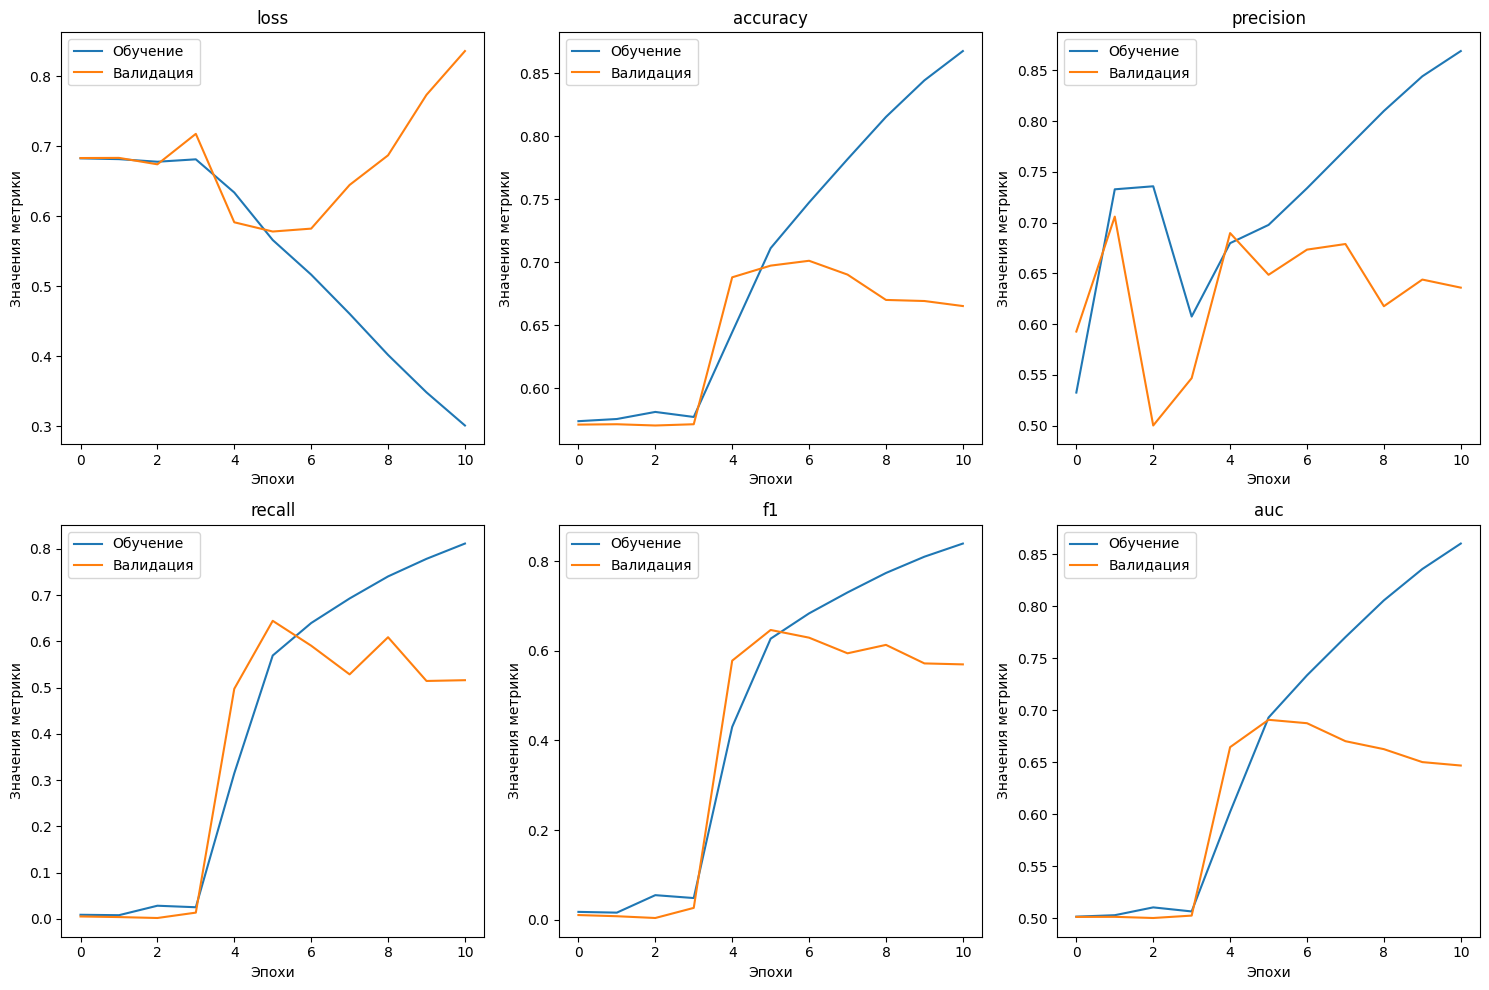

In [70]:
plot_metrics(history, 'GRU')

In [71]:
simple_gru_model.load_state_dict(torch.load('simple_GRU.pth', weights_only=True))

<All keys matched successfully>

## Оценка Simple GRU

In [72]:
loss_eval, metrics_eval, labels_eval, preds_eval = eval_model(simple_gru_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 878/878 [00:06<00:00, 132.60it/s]


In [73]:
print(loss_eval),print(metrics_eval)

0.5727982322827558
{'accuracy': 0.7023534019297184, 'precision': 0.656386922817661, 'recall': 0.6452948972829688, 'F1': 0.6507936507936508, 'AUC': 0.695329309397026, 'loss': 0.5727982322827558}


(None, None)

In [74]:
labels_eval = np.array(labels_eval, dtype=np.int32)
preds_eval = np.array(preds_eval, dtype=np.int32)

show_metrics(labels_eval, preds_eval, f'Репорт GRU')


                Репорт GRU
 auc: 0.695329309397026             
 report:                                
              precision    recall  f1-score   support

           0       0.74      0.75      0.74     16015
           1       0.66      0.65      0.65     12072

    accuracy                           0.70     28087
   macro avg       0.70      0.70      0.70     28087
weighted avg       0.70      0.70      0.70     28087


    


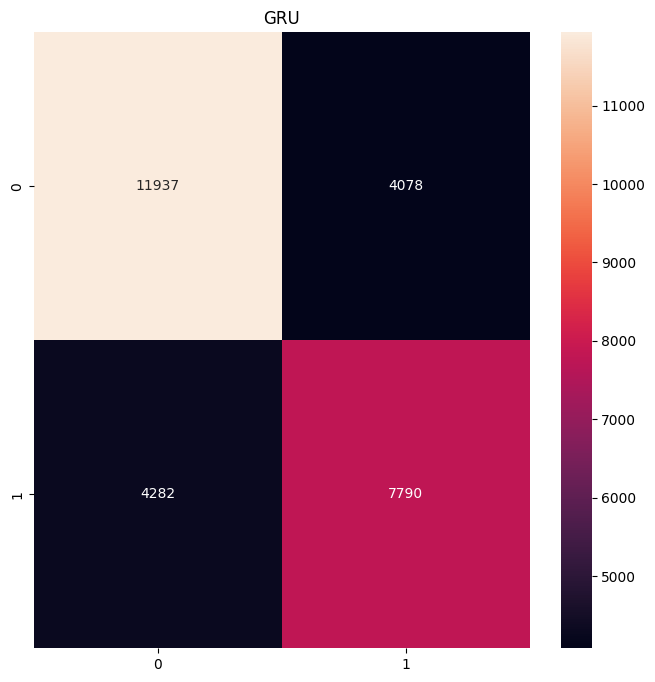

In [75]:
show_confusion_matrix(labels_eval, preds_eval, 'GRU')

In [76]:
# metrics_eval

['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.7024, 0.6564, 0.6453, 0.6508, 0.6953, 0.5728]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


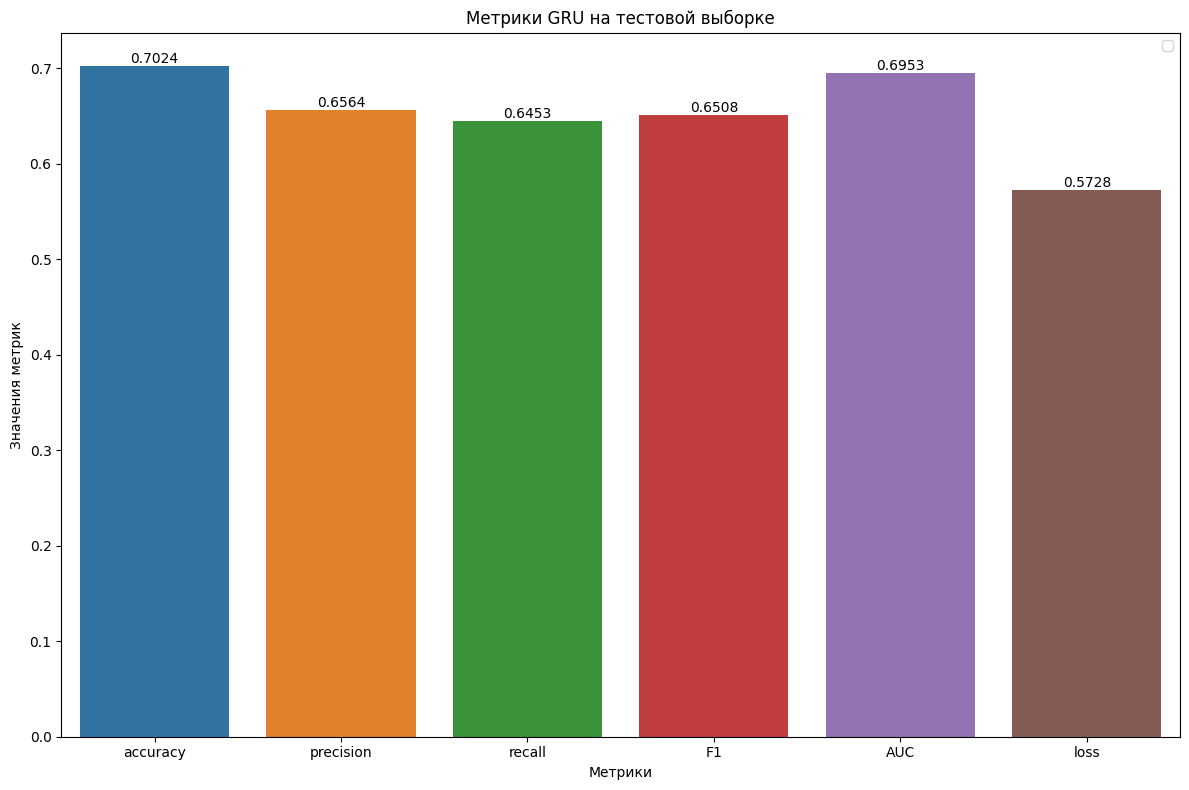

In [77]:
plot_metrics_eval(metrics_eval,'GRU')

# Bidirectional LSTM

In [78]:
class Bid_Lstm_model(nn.Module):
    def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, output_dim, dropout_rate, num_layers):
        super(Bid_Lstm_model, self).__init__()
        embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        # self.embedding.weight.requires_grad = False # заморозка весов для эмбеддинга
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.lstm = nn.LSTM(
                            input_size=embedding_matrix.shape[1],
                            hidden_size=hidden_dim,
                            batch_first=True,
                            bidirectional=True,
                            num_layers = num_layers,
                            dropout= dropout_rate if num_layers > 1 else 0,
                           )
        self.fc1 = nn.Linear(2*hidden_dim, 128)
        self.batch_norm_1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(128, 64)
        self.batch_norm_2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(64, output_dim)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        lstm_out,_ = self.lstm(embedded)
        # lstm_out = lstm_out[:, -1, :]  # Берем последний таймстеп
        lstm_out = torch.max(lstm_out, dim=1)[0]
        fc1_out = self.fc1(lstm_out)
        fc1_out = self.batch_norm_1(fc1_out)
        fc1_out = self.relu(fc1_out)
        fc1_out = self.dropout1(fc1_out)
        fc2_out = self.fc2(fc1_out)
        fc2_out = self.batch_norm_2(fc2_out)
        fc2_out = self.relu(fc2_out)
        fc2_out = self.dropout2(fc2_out)
        
        output = self.fc3(fc2_out)
        return output
        

In [79]:
# print(simple_lstm_model)

## Обучение

In [80]:
#Гиперпараметры
embedding_dim = 300
hidden_dim = 256
output_dim = 1
lr = 0.005
num_epochs = 100
num_layers = 1
dropout_rate = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [81]:

bid_simple_lstm_model = Bid_Lstm_model(vocab_size=len(vocabulary),
                              embedding_matrix=embedding_matrix, 
                              embedding_dim=embedding_matrix.shape[1],
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim,
                              dropout_rate=dropout_rate,
                              num_layers=num_layers)

In [82]:
init_weights(bid_simple_lstm_model)

In [83]:
print(bid_simple_lstm_model)

Bid_Lstm_model(
  (embedding): Embedding(50876, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [84]:
criterion = nn.BCEWithLogitsLoss() 
optimizer = optim.AdamW(bid_simple_lstm_model.parameters(), lr=lr, weight_decay=0.0001)
early_stopping = Early_stopping(patience=4, delta=0.001, save_path='bid_lstm_model.pth')

In [85]:
bid_simple_lstm_model.to(device)

Bid_Lstm_model(
  (embedding): Embedding(50876, 300)
  (embedding_dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (batch_norm_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [86]:
history, grad_logs = train_model(bid_simple_lstm_model,
                      train_loader, 
                      valid_loader, 
                      criterion, 
                      optimizer, 
                      device, 
                      num_epochs,
                      early_stopping = early_stopping  
                     )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [01:25<2:21:13, 85.59s/it]

Train Loss: 0.6001 | Train Acc: 0.6851 |  Train Precision: 0.6787 | Train Recall: 0.4967 |  Train F1: 0.5736 | Train AUC: 0.6609
Val Loss: 0.5830 | Val Acc: 0.7036 |  Val Precision: 0.7435 | Val Recall: 0.4730 |  Val F1: 0.5781 | Val AUC: 0.6751
Best loss: 0.5830107522862298

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [02:51<2:20:06, 85.78s/it]

Train Loss: 0.5874 | Train Acc: 0.6976 |  Train Precision: 0.6946 | Train Recall: 0.5190 |  Train F1: 0.5941 | Train AUC: 0.6747
Val Loss: 0.5797 | Val Acc: 0.6992 |  Val Precision: 0.7469 | Val Recall: 0.4531 |  Val F1: 0.5640 | Val AUC: 0.6688
Best loss: 0.5796808451414108

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [04:17<2:18:54, 85.93s/it]

Train Loss: 0.5792 | Train Acc: 0.7043 |  Train Precision: 0.6999 | Train Recall: 0.5364 |  Train F1: 0.6074 | Train AUC: 0.6827
Val Loss: 0.5791 | Val Acc: 0.6941 |  Val Precision: 0.7698 | Val Recall: 0.4103 |  Val F1: 0.5353 | Val AUC: 0.6590

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [05:43<2:17:24, 85.88s/it]

Train Loss: 0.5749 | Train Acc: 0.7075 |  Train Precision: 0.7044 | Train Recall: 0.5409 |  Train F1: 0.6119 | Train AUC: 0.6861
Val Loss: 0.5730 | Val Acc: 0.7046 |  Val Precision: 0.7254 | Val Recall: 0.5022 |  Val F1: 0.5935 | Val AUC: 0.6796
Best loss: 0.5729752970593316

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [07:09<2:16:13, 86.03s/it]

Train Loss: 0.5713 | Train Acc: 0.7106 |  Train Precision: 0.7059 | Train Recall: 0.5507 |  Train F1: 0.6187 | Train AUC: 0.6901
Val Loss: 0.5789 | Val Acc: 0.7022 |  Val Precision: 0.7637 | Val Recall: 0.4438 |  Val F1: 0.5614 | Val AUC: 0.6702

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [08:35<2:14:52, 86.09s/it]

Train Loss: 0.5683 | Train Acc: 0.7120 |  Train Precision: 0.7095 | Train Recall: 0.5497 |  Train F1: 0.6194 | Train AUC: 0.6912
Val Loss: 0.5853 | Val Acc: 0.6911 |  Val Precision: 0.7715 | Val Recall: 0.3987 |  Val F1: 0.5257 | Val AUC: 0.6549

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [10:02<2:13:35, 86.19s/it]

Train Loss: 0.5649 | Train Acc: 0.7146 |  Train Precision: 0.7106 | Train Recall: 0.5580 |  Train F1: 0.6251 | Train AUC: 0.6945
Val Loss: 0.5708 | Val Acc: 0.7101 |  Val Precision: 0.6963 | Val Recall: 0.5758 |  Val F1: 0.6304 | Val AUC: 0.6934
Best loss: 0.5707625214542661

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [11:28<2:11:58, 86.07s/it]

Train Loss: 0.5634 | Train Acc: 0.7150 |  Train Precision: 0.7103 | Train Recall: 0.5600 |  Train F1: 0.6263 | Train AUC: 0.6951
Val Loss: 0.5678 | Val Acc: 0.7112 |  Val Precision: 0.7121 | Val Recall: 0.5496 |  Val F1: 0.6204 | Val AUC: 0.6912
Best loss: 0.567822447844914

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [12:53<2:10:21, 85.95s/it]

Train Loss: 0.5591 | Train Acc: 0.7176 |  Train Precision: 0.7119 | Train Recall: 0.5670 |  Train F1: 0.6313 | Train AUC: 0.6982
Val Loss: 0.5683 | Val Acc: 0.7092 |  Val Precision: 0.7356 | Val Recall: 0.5038 |  Val F1: 0.5980 | Val AUC: 0.6838

Epoch 10/100
--------------------
-----Обучение-----


Epochs:  10%|█         | 10/100 [14:19<2:08:38, 85.76s/it]

Train Loss: 0.5567 | Train Acc: 0.7200 |  Train Precision: 0.7147 | Train Recall: 0.5714 |  Train F1: 0.6351 | Train AUC: 0.7009
Val Loss: 0.5694 | Val Acc: 0.7119 |  Val Precision: 0.7259 | Val Recall: 0.5287 |  Val F1: 0.6118 | Val AUC: 0.6892

Epoch 11/100
--------------------
-----Обучение-----


Epochs:  11%|█         | 11/100 [15:44<2:07:09, 85.73s/it]

Train Loss: 0.5537 | Train Acc: 0.7218 |  Train Precision: 0.7165 | Train Recall: 0.5750 |  Train F1: 0.6380 | Train AUC: 0.7029
Val Loss: 0.5692 | Val Acc: 0.7106 |  Val Precision: 0.7172 | Val Recall: 0.5383 |  Val F1: 0.6150 | Val AUC: 0.6893

Epoch 12/100
--------------------
-----Обучение-----


Epochs:  11%|█         | 11/100 [17:10<2:18:57, 93.68s/it]

Train Loss: 0.5535 | Train Acc: 0.7214 |  Train Precision: 0.7169 | Train Recall: 0.5731 |  Train F1: 0.6370 | Train AUC: 0.7024
Val Loss: 0.5727 | Val Acc: 0.7041 |  Val Precision: 0.7387 | Val Recall: 0.4809 |  Val F1: 0.5826 | Val AUC: 0.6765
Early stopping triggered! Best model weights saved.
Stop after 11 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


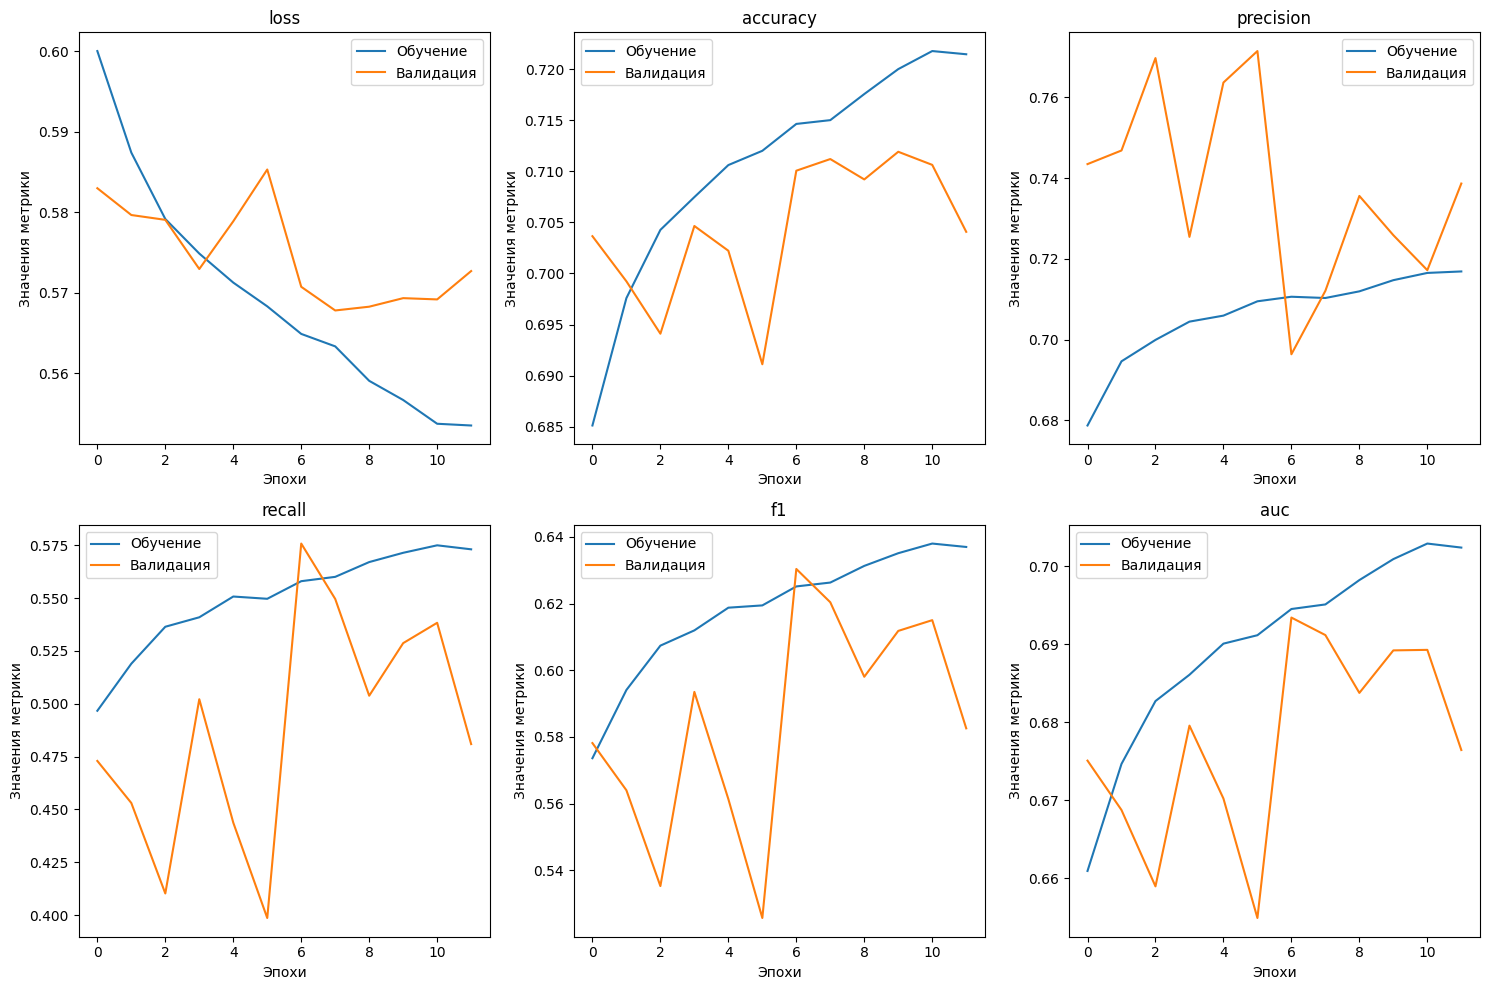

In [87]:
plot_metrics(history, 'Двунаправленная LSTM')

In [88]:
bid_simple_lstm_model.load_state_dict(torch.load('bid_lstm_model.pth', weights_only=True))

<All keys matched successfully>

## Оценка

In [89]:
loss_eval, history_eval, labels, preds = eval_model(bid_simple_lstm_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 878/878 [00:09<00:00, 90.11it/s]


In [90]:
show_metrics(labels, preds, 'Двунаправленная LSTM')


                Двунаправленная LSTM
 auc: 0.6918531970834997             
 report:                                
              precision    recall  f1-score   support

         0.0       0.71      0.84      0.77     16015
         1.0       0.72      0.54      0.62     12072

    accuracy                           0.71     28087
   macro avg       0.71      0.69      0.69     28087
weighted avg       0.71      0.71      0.70     28087


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.7128, 0.7203, 0.5425, 0.6189, 0.6919, 0.5644]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


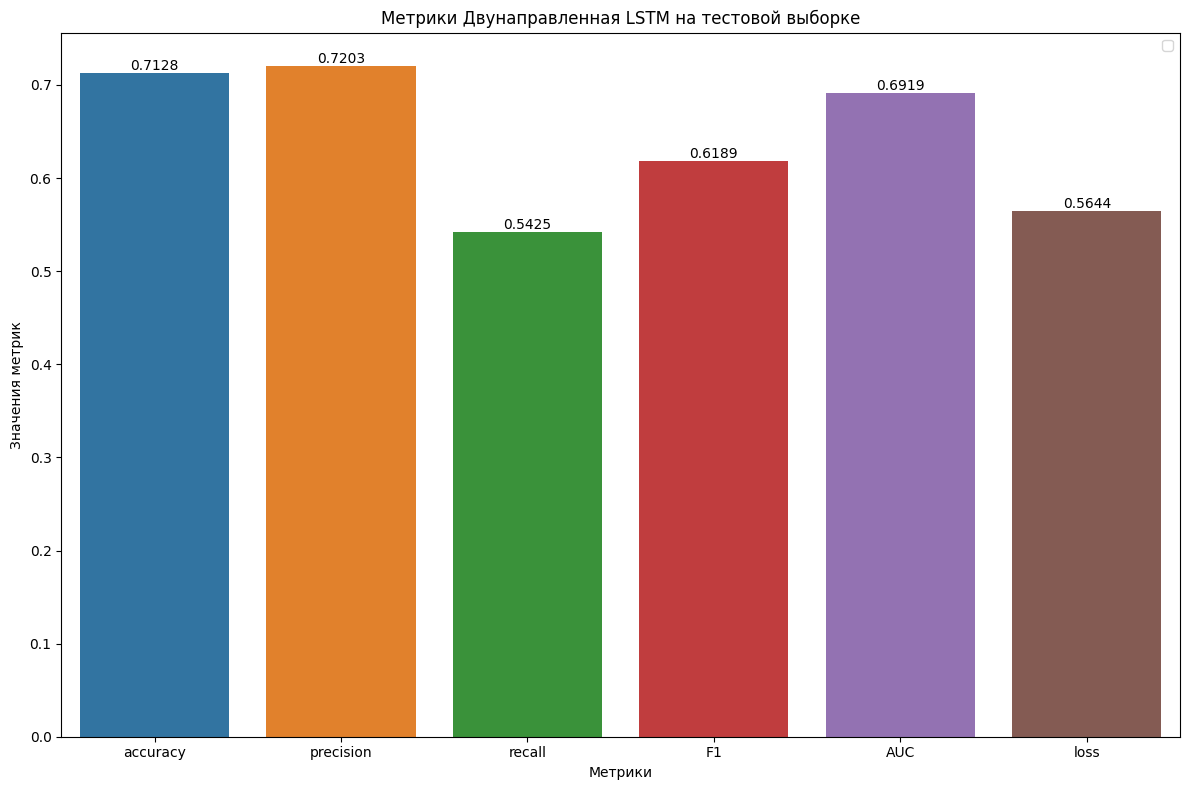

In [91]:
plot_metrics_eval(history_eval, "Двунаправленная LSTM")

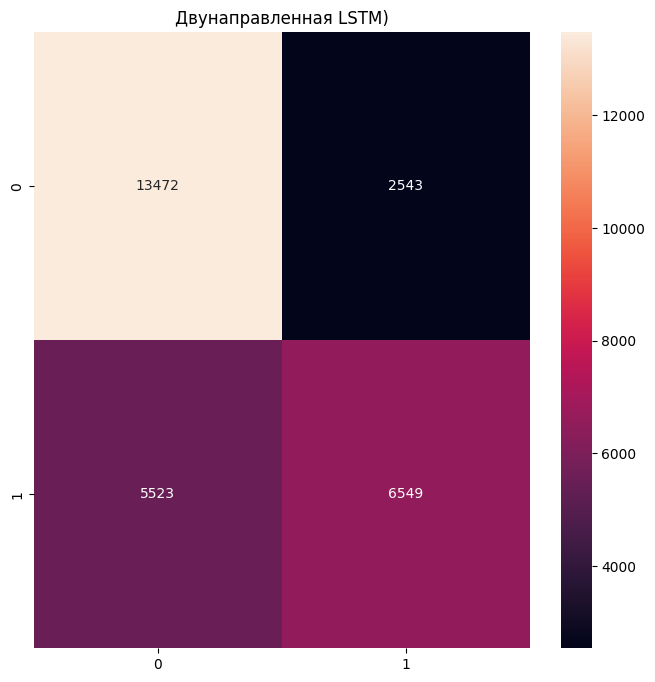

In [92]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM)')

# LSTM + CNN

In [93]:
class lstm_cnn(nn.Module):
   def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernel_size, output_dim, dropout_rate, num_layers):
       super(lstm_cnn, self).__init__()
       embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
       self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
       self.dropout = nn.Dropout(dropout_rate)
       self.lstm = nn.LSTM(input_size=embedding_dim, 
                           hidden_size=hidden_dim, 
                           batch_first=True,
                           bidirectional=True,
                           num_layers=num_layers, 
                           dropout=dropout_rate if num_layers > 1 else 0,
                           )
       # self.ln = nn.LayerNorm(hidden_dim * 2)
       self.conv1 = nn.Conv1d(in_channels = hidden_dim * 2, 
                              out_channels=num_filters, 
                              kernel_size=kernel_size,
                              padding='same')
       self.bn = nn.BatchNorm1d(num_filters)
       self.relu = torch.nn.ReLU()
       
       self.fc1 = nn.Linear(num_filters, output_dim) 
   def forward(self, x):
       embedded = self.dropout(self.embedding(x))
       lstm_out,_ = self.lstm(embedded)
       # lstm_out = self.ln(lstm_out)
       lstm_out = lstm_out.permute(0, 2, 1)
       conv_out = self.conv1(lstm_out)
       conv_out = self.bn(conv_out)
       conv_out = self.relu(conv_out)
       pool = F.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2)
       pool = self.dropout(pool)
       # print("Размер перед fc:", pool.shape)
       out = self.fc1(pool)
       return out

## Обучение LSTM + CNN

In [94]:
# Гиперпараметры
embedding_dim = 300
hidden_dim = 256
num_layers = 1
kernel_size = 3
num_filters = 128
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [95]:
lstm_cnn_model = lstm_cnn(vocab_size=len(vocabulary), 
                          embedding_matrix=embedding_matrix,
                          embedding_dim=embedding_dim,
                          hidden_dim=hidden_dim,
                          num_layers=num_layers,
                          num_filters=num_filters,
                          kernel_size=kernel_size,
                          output_dim=output_dim,
                          dropout_rate=0.25
                         )

In [96]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(lstm_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping = Early_stopping(patience=5, save_path="lstm_cnn.pth")
lstm_cnn_model.to(device)

lstm_cnn(
  (embedding): Embedding(50876, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv1): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)

In [97]:
print(lstm_cnn_model)

lstm_cnn(
  (embedding): Embedding(50876, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv1): Conv1d(512, 128, kernel_size=(3,), stride=(1,), padding=same)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc1): Linear(in_features=128, out_features=1, bias=True)
)


In [98]:
history, _ = train_model(model=lstm_cnn_model,
            train_loader=train_loader,
            valid_loader=valid_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=num_epochs,
            early_stopping=early_stopping
           )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [01:50<3:01:38, 110.09s/it]

Train Loss: 0.6232 | Train Acc: 0.6707 |  Train Precision: 0.6525 | Train Recall: 0.4875 |  Train F1: 0.5580 | Train AUC: 0.6472
Val Loss: 0.5866 | Val Acc: 0.6968 |  Val Precision: 0.6728 | Val Recall: 0.5721 |  Val F1: 0.6184 | Val AUC: 0.6814
Best loss: 0.5866237793649945

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [03:39<2:59:00, 109.59s/it]

Train Loss: 0.5949 | Train Acc: 0.6889 |  Train Precision: 0.6815 | Train Recall: 0.5075 |  Train F1: 0.5818 | Train AUC: 0.6656
Val Loss: 0.5824 | Val Acc: 0.6984 |  Val Precision: 0.7323 | Val Recall: 0.4690 |  Val F1: 0.5718 | Val AUC: 0.6700
Best loss: 0.5824387052229473

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [05:28<2:57:08, 109.58s/it]

Train Loss: 0.5829 | Train Acc: 0.6973 |  Train Precision: 0.6896 | Train Recall: 0.5275 |  Train F1: 0.5978 | Train AUC: 0.6755
Val Loss: 0.5766 | Val Acc: 0.7051 |  Val Precision: 0.7038 | Val Recall: 0.5406 |  Val F1: 0.6115 | Val AUC: 0.6847
Best loss: 0.576640818800245

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [07:18<2:55:25, 109.64s/it]

Train Loss: 0.5733 | Train Acc: 0.7070 |  Train Precision: 0.7000 | Train Recall: 0.5475 |  Train F1: 0.6144 | Train AUC: 0.6865
Val Loss: 0.5850 | Val Acc: 0.6945 |  Val Precision: 0.7839 | Val Recall: 0.3983 |  Val F1: 0.5283 | Val AUC: 0.6579

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [09:07<2:53:25, 109.53s/it]

Train Loss: 0.5639 | Train Acc: 0.7116 |  Train Precision: 0.7035 | Train Recall: 0.5596 |  Train F1: 0.6234 | Train AUC: 0.6921
Val Loss: 0.5699 | Val Acc: 0.7061 |  Val Precision: 0.7215 | Val Recall: 0.5138 |  Val F1: 0.6002 | Val AUC: 0.6823
Best loss: 0.5698608841214862

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [10:57<2:51:24, 109.41s/it]

Train Loss: 0.5558 | Train Acc: 0.7186 |  Train Precision: 0.7101 | Train Recall: 0.5746 |  Train F1: 0.6352 | Train AUC: 0.7001
Val Loss: 0.5794 | Val Acc: 0.7049 |  Val Precision: 0.6520 | Val Recall: 0.6706 |  Val F1: 0.6612 | Val AUC: 0.7007

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [12:46<2:49:41, 109.48s/it]

Train Loss: 0.5449 | Train Acc: 0.7268 |  Train Precision: 0.7205 | Train Recall: 0.5871 |  Train F1: 0.6470 | Train AUC: 0.7089
Val Loss: 0.5713 | Val Acc: 0.7105 |  Val Precision: 0.7107 | Val Recall: 0.5493 |  Val F1: 0.6196 | Val AUC: 0.6905

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [14:36<2:47:55, 109.52s/it]

Train Loss: 0.5339 | Train Acc: 0.7339 |  Train Precision: 0.7274 | Train Recall: 0.6012 |  Train F1: 0.6583 | Train AUC: 0.7168
Val Loss: 0.5809 | Val Acc: 0.7058 |  Val Precision: 0.7057 | Val Recall: 0.5400 |  Val F1: 0.6118 | Val AUC: 0.6853

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [16:26<2:46:14, 109.61s/it]

Train Loss: 0.5170 | Train Acc: 0.7453 |  Train Precision: 0.7378 | Train Recall: 0.6249 |  Train F1: 0.6766 | Train AUC: 0.7299
Val Loss: 0.5930 | Val Acc: 0.7008 |  Val Precision: 0.7329 | Val Recall: 0.4769 |  Val F1: 0.5779 | Val AUC: 0.6731

Epoch 10/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [18:16<3:04:42, 121.79s/it]

Train Loss: 0.4967 | Train Acc: 0.7589 |  Train Precision: 0.7524 | Train Recall: 0.6478 |  Train F1: 0.6962 | Train AUC: 0.7447
Val Loss: 0.6108 | Val Acc: 0.7022 |  Val Precision: 0.7326 | Val Recall: 0.4826 |  Val F1: 0.5819 | Val AUC: 0.6750
Early stopping triggered! Best model weights saved.
Stop after 9 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


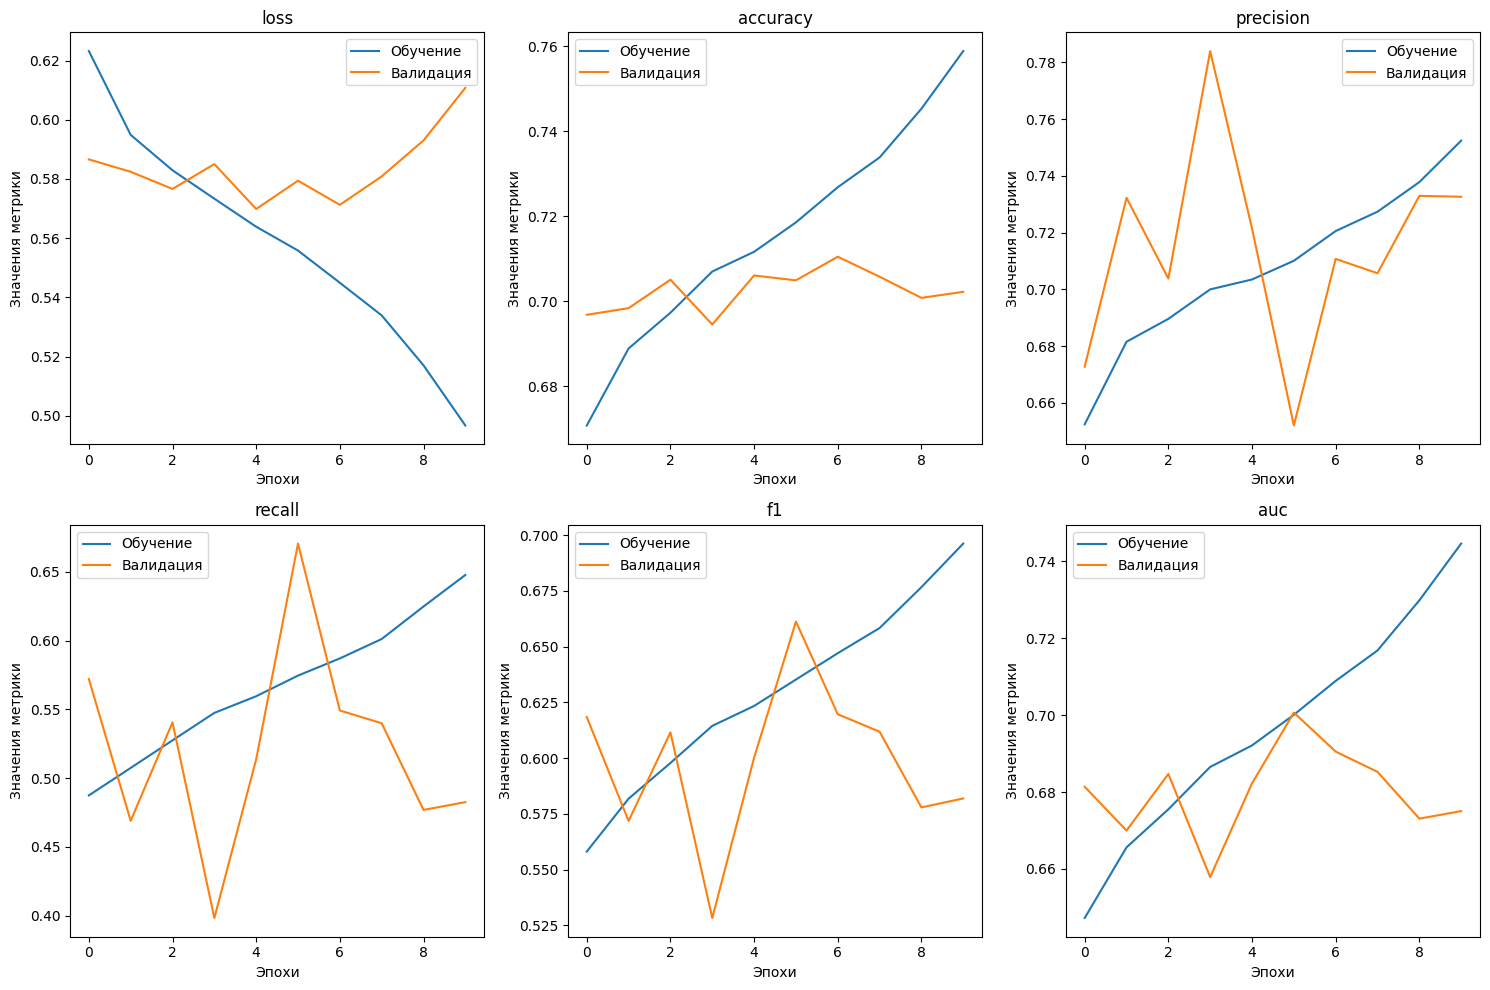

In [99]:
plot_metrics(history, "LSTM + CNN")

In [100]:
lstm_cnn_model.load_state_dict(torch.load('/kaggle/working/lstm_cnn.pth', weights_only=True))

<All keys matched successfully>

## Оценка LSTM + CNN

In [101]:
loss_eval, history_eval, labels, preds = eval_model(lstm_cnn_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 878/878 [00:10<00:00, 82.17it/s]


In [102]:
show_metrics(labels, preds, 'Комбинация двунаправленной LSTM и CNN')


                Комбинация двунаправленной LSTM и CNN
 auc: 0.685282508301218             
 report:                                
              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77     16015
         1.0       0.73      0.52      0.60     12072

    accuracy                           0.71     28087
   macro avg       0.71      0.69      0.69     28087
weighted avg       0.71      0.71      0.70     28087


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.7092, 0.7286, 0.5152, 0.6036, 0.6853, 0.5665]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


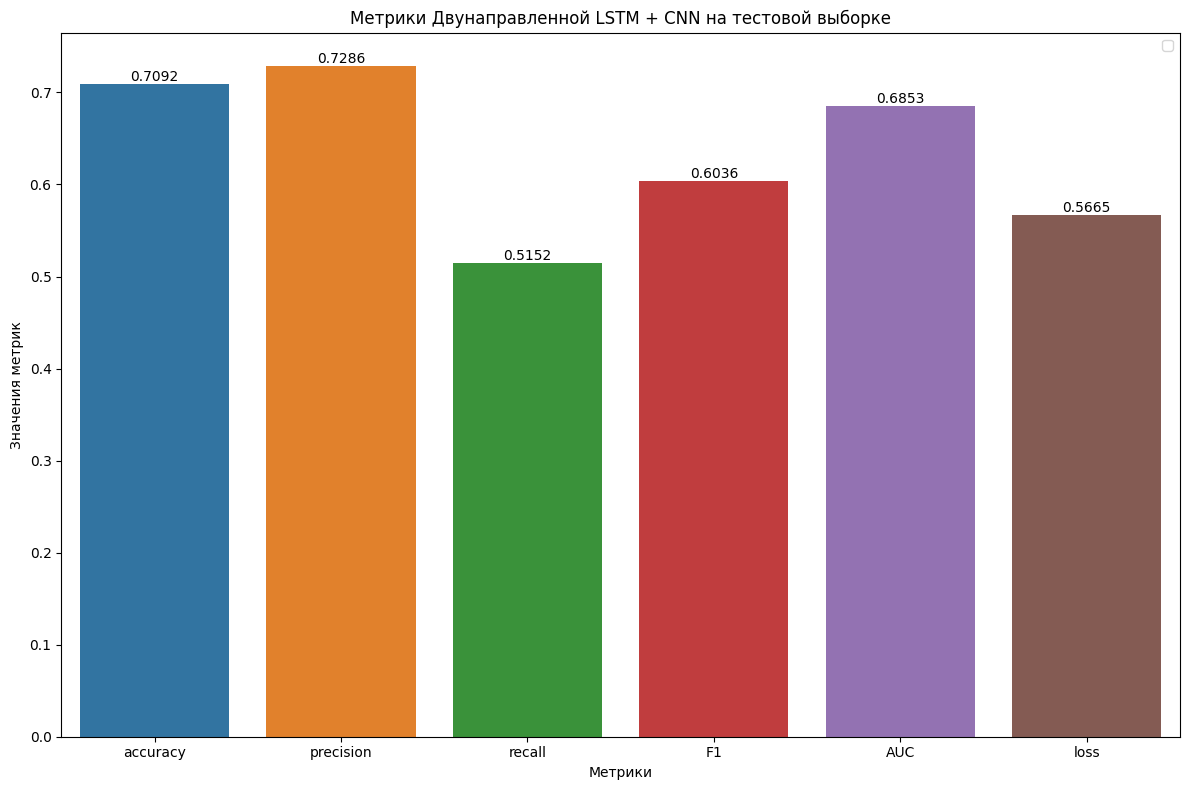

In [103]:
plot_metrics_eval(history_eval, "Двунаправленной LSTM + CNN")

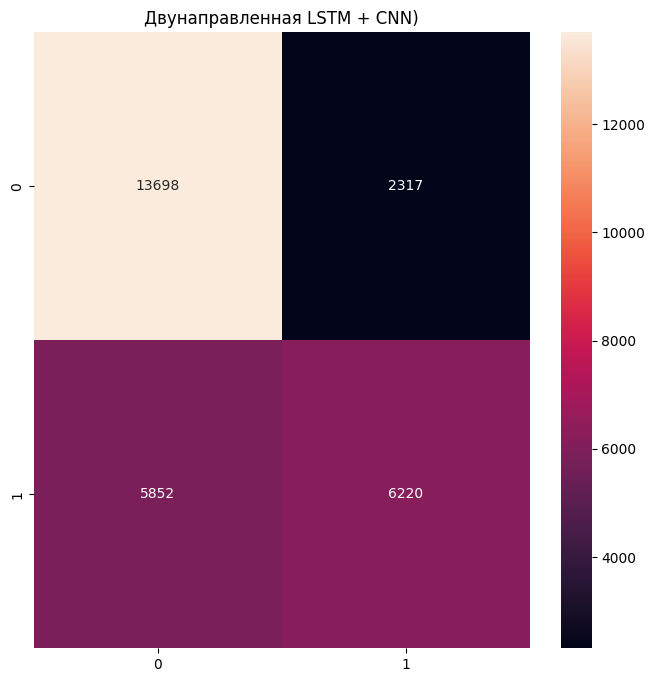

In [104]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM + CNN)')

# LSTM + paralel CNN

In [105]:
class lstm_parallel_cnn(nn.Module):
   def __init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernels_sizes, output_dim, dropout_rate, num_layers):
       super(lstm_parallel_cnn, self).__init__()
       embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
       self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
       self.dropout = nn.Dropout(dropout_rate)
       self.lstm = nn.LSTM(input_size=embedding_dim, 
                           hidden_size=hidden_dim, 
                           batch_first=True,
                           bidirectional=True,
                           num_layers=num_layers, 
                           dropout=dropout_rate if num_layers > 1 else 0,
                           )
       # self.ln = nn.LayerNorm(hidden_dim * 2)
       
       # Список сверточных слоев
       self.conv_lst = nn.ModuleList([
           nn.Sequential(
               nn.Conv1d(in_channels=hidden_dim*2,out_channels=num_filters,kernel_size=ks),
               nn.BatchNorm1d(num_filters),
               nn.ReLU(),
               nn.Dropout(dropout_rate),
               nn.AdaptiveMaxPool1d(1),
               nn.Flatten()
                        ) for ks in kernels_sizes])
       
       self.bn = nn.BatchNorm1d(num_filters)
       self.relu = torch.nn.ReLU()
       
       self.fc1 = nn.Linear(num_filters*len(kernels_sizes), output_dim) 
   def forward(self, x):
       embedded = self.dropout(self.embedding(x))
       lstm_out,_ = self.lstm(embedded)
       # lstm_out = self.ln(lstm_out)
       lstm_out = lstm_out.permute(0, 2, 1)
       conv_outs = [conv(lstm_out) for conv in self.conv_lst]
       conv_out_cat = torch.cat(conv_outs, dim=1)
       out = self.fc1(conv_out_cat)
       return out

## Обучение LSTM + parallel CNN

In [106]:
lstm_parallel_cnn.__init__

<function __main__.lstm_parallel_cnn.__init__(self, vocab_size, embedding_matrix, embedding_dim, hidden_dim, num_filters, kernels_sizes, output_dim, dropout_rate, num_layers)>

In [107]:
# Гиперпараметры
embedding_dim = 300
hidden_dim = 256
num_layers = 1
kernels_sizes = [2,3,4]
num_filters = 256
output_dim = 1
lr = 0.001
num_epochs = 100
dropout_rate = 0.25
weight_decay = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [108]:
lstm_parallel_cnn_model = lstm_parallel_cnn(vocab_size=len(vocabulary), 
                                            embedding_matrix=embedding_matrix,
                                            embedding_dim=embedding_dim,
                                            hidden_dim=hidden_dim,
                                            num_filters=num_filters,
                                            kernels_sizes=kernels_sizes,
                                            output_dim=output_dim,
                                            dropout_rate=dropout_rate,
                                            num_layers=num_layers)
                                            

In [109]:
print(lstm_parallel_cnn_model)

lstm_parallel_cnn(
  (embedding): Embedding(50876, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv_lst): ModuleList(
    (0): Sequential(
      (0): Conv1d(512, 256, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (1): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (2): Sequential(
      (0): Conv1d(512, 256, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [110]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(lstm_parallel_cnn_model.parameters(), lr=lr, weight_decay=weight_decay)
early_stopping = Early_stopping(patience=5, save_path="lstm_parallel_cnn.pth")
lstm_parallel_cnn_model.to(device)

lstm_parallel_cnn(
  (embedding): Embedding(50876, 300)
  (dropout): Dropout(p=0.25, inplace=False)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (conv_lst): ModuleList(
    (0): Sequential(
      (0): Conv1d(512, 256, kernel_size=(2,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (1): Sequential(
      (0): Conv1d(512, 256, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.25, inplace=False)
      (4): AdaptiveMaxPool1d(output_size=1)
      (5): Flatten(start_dim=1, end_dim=-1)
    )
    (2): Sequential(
      (0): Conv1d(512, 256, kernel_size=(4,), stride=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [111]:
history, _ = train_model(model=lstm_parallel_cnn_model,
            train_loader=train_loader,
            valid_loader=valid_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            num_epochs=num_epochs,
            early_stopping=early_stopping
           )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
--------------------
-----Обучение-----


Epochs:   1%|          | 1/100 [02:58<4:55:12, 178.91s/it]

Train Loss: 0.6550 | Train Acc: 0.6742 |  Train Precision: 0.6561 | Train Recall: 0.4956 |  Train F1: 0.5647 | Train AUC: 0.6513
Val Loss: 0.6075 | Val Acc: 0.6709 |  Val Precision: 0.5976 | Val Recall: 0.7148 |  Val F1: 0.6510 | Val AUC: 0.6763
Best loss: 0.6074866035154888

Epoch 2/100
--------------------
-----Обучение-----


Epochs:   2%|▏         | 2/100 [05:58<4:52:36, 179.15s/it]

Train Loss: 0.5909 | Train Acc: 0.6921 |  Train Precision: 0.6793 | Train Recall: 0.5265 |  Train F1: 0.5932 | Train AUC: 0.6708
Val Loss: 0.5773 | Val Acc: 0.7014 |  Val Precision: 0.7155 | Val Recall: 0.5055 |  Val F1: 0.5924 | Val AUC: 0.6771
Best loss: 0.5773396044969559

Epoch 3/100
--------------------
-----Обучение-----


Epochs:   3%|▎         | 3/100 [08:57<4:49:32, 179.09s/it]

Train Loss: 0.5775 | Train Acc: 0.7006 |  Train Precision: 0.6857 | Train Recall: 0.5498 |  Train F1: 0.6103 | Train AUC: 0.6812
Val Loss: 0.5723 | Val Acc: 0.7088 |  Val Precision: 0.7007 | Val Recall: 0.5615 |  Val F1: 0.6235 | Val AUC: 0.6905
Best loss: 0.5723210104874202

Epoch 4/100
--------------------
-----Обучение-----


Epochs:   4%|▍         | 4/100 [11:56<4:46:24, 179.01s/it]

Train Loss: 0.5699 | Train Acc: 0.7076 |  Train Precision: 0.6947 | Train Recall: 0.5608 |  Train F1: 0.6206 | Train AUC: 0.6888
Val Loss: 0.5780 | Val Acc: 0.6994 |  Val Precision: 0.7671 | Val Recall: 0.4305 |  Val F1: 0.5515 | Val AUC: 0.6661

Epoch 5/100
--------------------
-----Обучение-----


Epochs:   5%|▌         | 5/100 [14:55<4:43:31, 179.07s/it]

Train Loss: 0.5626 | Train Acc: 0.7127 |  Train Precision: 0.6993 | Train Recall: 0.5721 |  Train F1: 0.6293 | Train AUC: 0.6946
Val Loss: 0.5669 | Val Acc: 0.7093 |  Val Precision: 0.6970 | Val Recall: 0.5715 |  Val F1: 0.6280 | Val AUC: 0.6923
Best loss: 0.5669208190270832

Epoch 6/100
--------------------
-----Обучение-----


Epochs:   6%|▌         | 6/100 [17:54<4:40:31, 179.06s/it]

Train Loss: 0.5506 | Train Acc: 0.7219 |  Train Precision: 0.7084 | Train Recall: 0.5910 |  Train F1: 0.6444 | Train AUC: 0.7051
Val Loss: 0.5895 | Val Acc: 0.6975 |  Val Precision: 0.7976 | Val Recall: 0.3960 |  Val F1: 0.5293 | Val AUC: 0.6602

Epoch 7/100
--------------------
-----Обучение-----


Epochs:   7%|▋         | 7/100 [20:52<4:37:14, 178.87s/it]

Train Loss: 0.5416 | Train Acc: 0.7303 |  Train Precision: 0.7165 | Train Recall: 0.6079 |  Train F1: 0.6578 | Train AUC: 0.7146
Val Loss: 0.5793 | Val Acc: 0.7007 |  Val Precision: 0.6406 | Val Recall: 0.6899 |  Val F1: 0.6643 | Val AUC: 0.6993

Epoch 8/100
--------------------
-----Обучение-----


Epochs:   8%|▊         | 8/100 [23:51<4:34:16, 178.87s/it]

Train Loss: 0.5241 | Train Acc: 0.7429 |  Train Precision: 0.7306 | Train Recall: 0.6288 |  Train F1: 0.6759 | Train AUC: 0.7282
Val Loss: 0.5885 | Val Acc: 0.6984 |  Val Precision: 0.7720 | Val Recall: 0.4222 |  Val F1: 0.5459 | Val AUC: 0.6642

Epoch 9/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [26:50<4:31:11, 178.81s/it]

Train Loss: 0.5098 | Train Acc: 0.7497 |  Train Precision: 0.7335 | Train Recall: 0.6487 |  Train F1: 0.6885 | Train AUC: 0.7368
Val Loss: 0.5797 | Val Acc: 0.7086 |  Val Precision: 0.6768 | Val Recall: 0.6153 |  Val F1: 0.6445 | Val AUC: 0.6971

Epoch 10/100
--------------------
-----Обучение-----


Epochs:   9%|▉         | 9/100 [29:49<5:01:30, 198.79s/it]

Train Loss: 0.5105 | Train Acc: 0.7530 |  Train Precision: 0.7398 | Train Recall: 0.6490 |  Train F1: 0.6914 | Train AUC: 0.7396
Val Loss: 0.5840 | Val Acc: 0.7058 |  Val Precision: 0.6709 | Val Recall: 0.6179 |  Val F1: 0.6433 | Val AUC: 0.6949
Early stopping triggered! Best model weights saved.
Stop after 9 epochs


<ipython-input-30-3aeef0aace76>:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i + 1)  # 2 строки, 3 столбца, i+1 — позиция графика


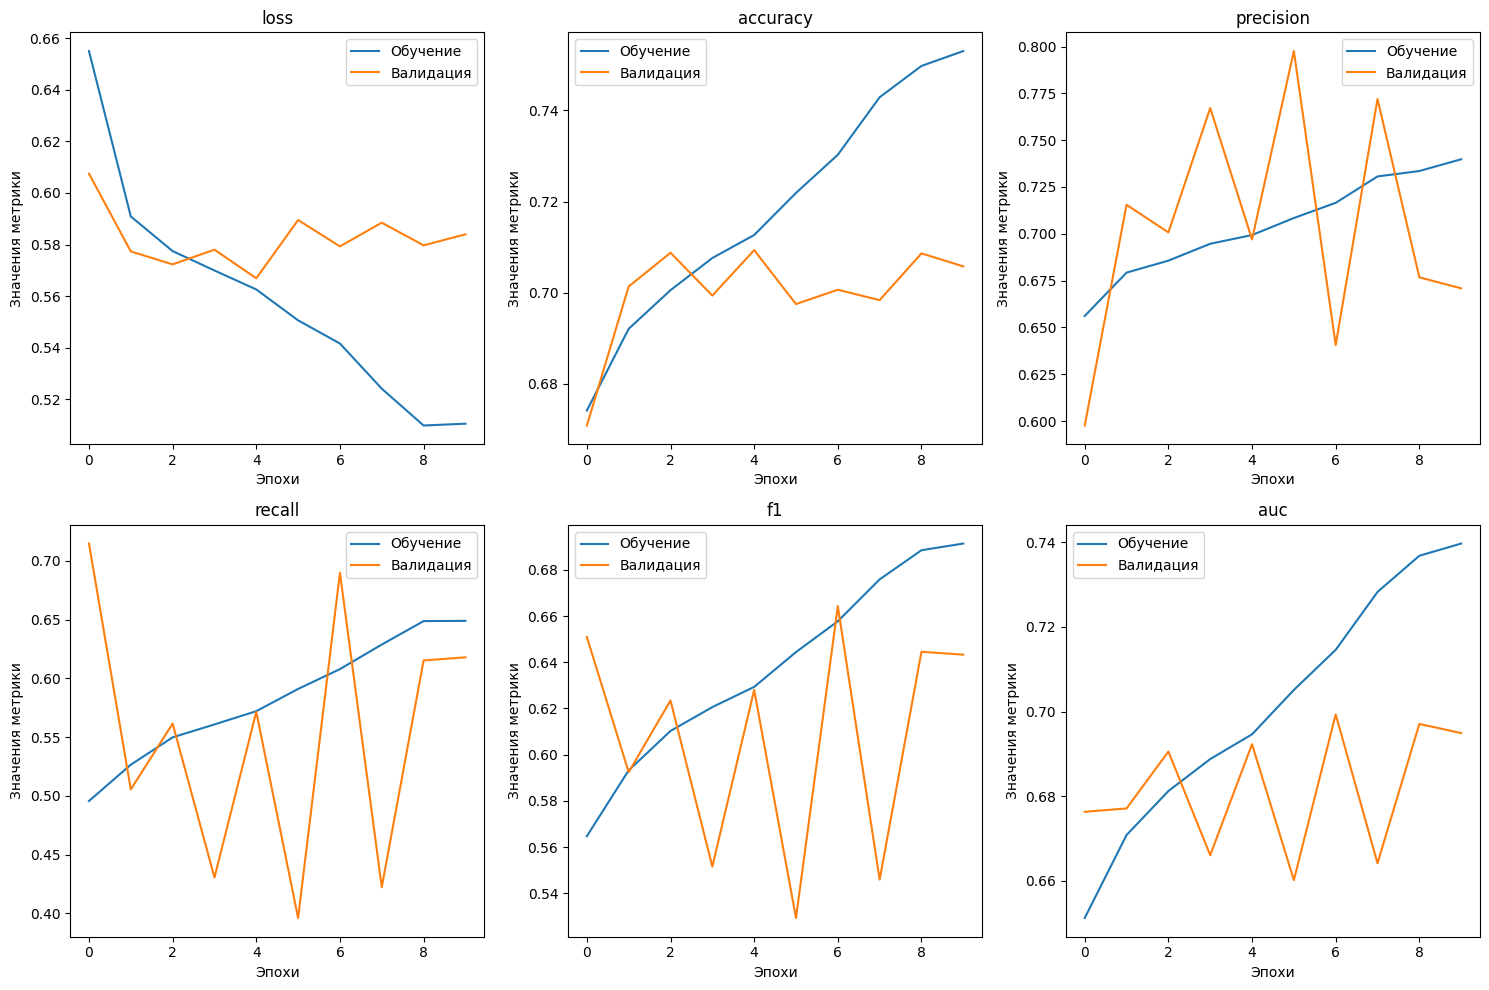

In [112]:
plot_metrics(history, "LSTM + параллельная CNN")

In [113]:
lstm_parallel_cnn_model.load_state_dict(torch.load('lstm_parallel_cnn.pth', weights_only=True))

<All keys matched successfully>

## Оценка LSTM + parallel CNN

In [114]:
loss_eval, history_eval, labels, preds = eval_model(lstm_parallel_cnn_model, test_loader, criterion, device)

Evaluating(test): 100%|██████████| 878/878 [00:16<00:00, 53.89it/s]


In [115]:
show_metrics(labels, preds, 'Двунаправленная LSTM + параллельный CNN')



                Двунаправленная LSTM + параллельный CNN
 auc: 0.6948545251542053             
 report:                                
              precision    recall  f1-score   support

         0.0       0.72      0.82      0.76     16015
         1.0       0.70      0.57      0.63     12072

    accuracy                           0.71     28087
   macro avg       0.71      0.69      0.70     28087
weighted avg       0.71      0.71      0.71     28087


    


['accuracy', 'precision', 'recall', 'F1', 'AUC', 'loss']
[0.7124, 0.7047, 0.5697, 0.63, 0.6949, 0.564]


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


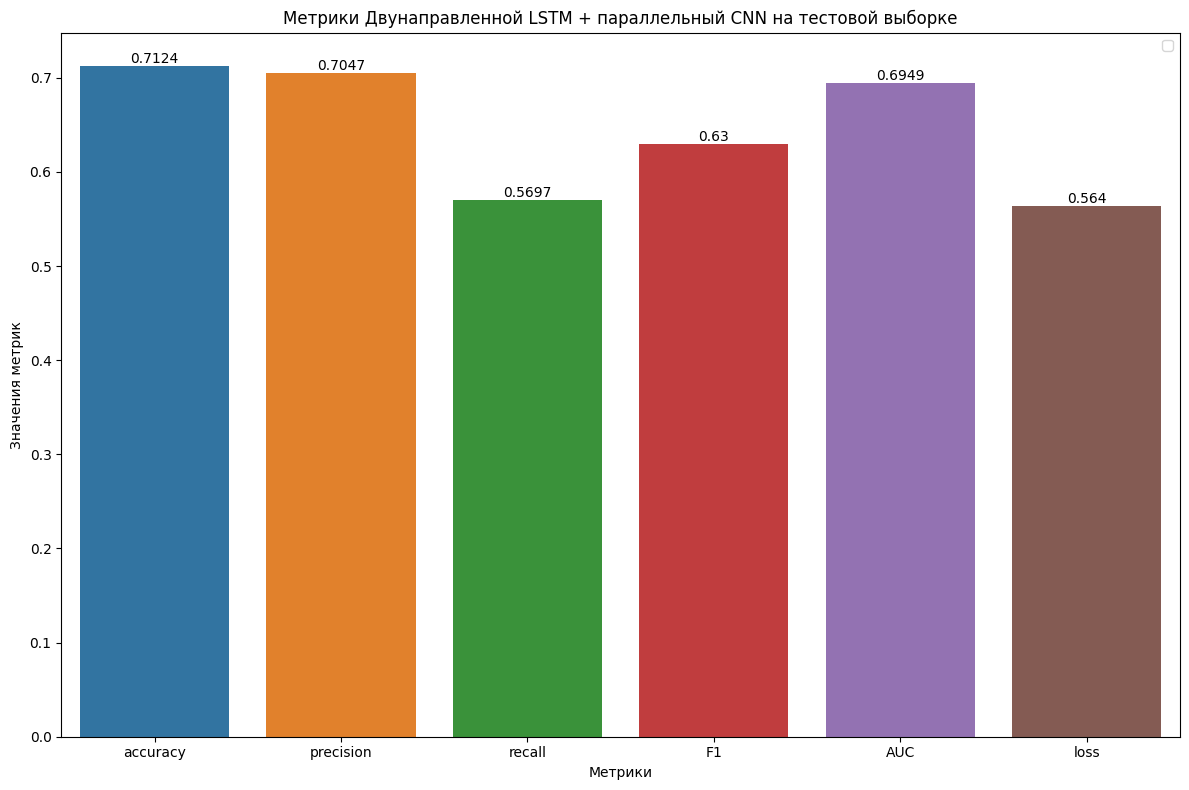

In [116]:
plot_metrics_eval(history_eval, "Двунаправленной LSTM + параллельный CNN")

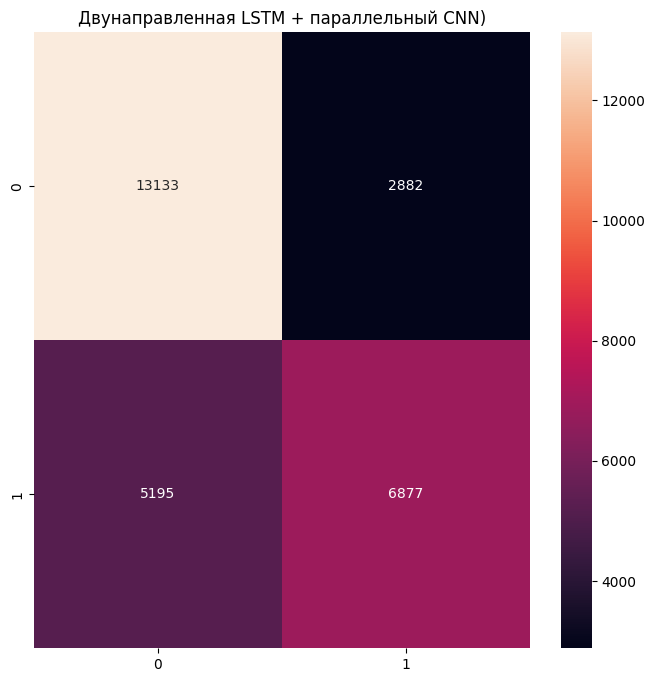

In [117]:
show_confusion_matrix(labels, preds, f'Двунаправленная LSTM + параллельный CNN)')